In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessorV2

%matplotlib inline

In [70]:
# name, epidemicforecasting.org code, OxCGRT code
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ('Albania','AL','ALB'),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
#     ('Georgia','GE','GEO'),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
#     ('Latvia','LV','LVA'),
    ("South Korea", "KR", "KOR"),
#     ('Malta','MT','MLT'),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ('Norway','NO','NOR'),
    ('New Zealand','NZ','NZL'),
    ("Poland","PL", "POL"),
    ('Portugal','PT','PRT'),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF"),
]

region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])
regions_oxcgrt = list([x for _, _, x in region_info])

# OxCGRT
oxcgrt_cm_cols = ["C1_School closing", "C1_Flag", "C4_Restrictions on gatherings", "C4_Flag", "C6_Stay at home requirements",
              "C6_Flag", "H2_Testing policy", "H3_Contact tracing"]

oxcgrt_filter = [
    ("Symptomatic Testing", [(6, [2, 3])]),
    ("Public Testing", [(6, [3])]),
    ("Limited Contact Tracing", [(7, [2, 3])]),
    ("Extensive Contact Tracing", [(7, [2, 3])]),
    ("Gatherings lim. 1000", [(2, [2, 3, 4]), (3, [1])]),
    ("Gatherings lim. 100", [(2, [3, 4]), (3, [1])] ),
    ("Gatherings lim. 10", [(2, [4]), (3, [1])] ),
    ("Some Schools Closed", [(0, [3, 2]), (1, [1])]),
    ("All Schools Closed", [(0, [3]), (1, [1])] ),
#     ("Stay at Home, Rec", [(4, [1, 2, 3]), (5, [1])] ),
    ("Stay at Home, Req", [(4, [2, 3]), (5, [1])] ),
]

epifor_features = [
 'Mask wearing over 70%',
 'Business suspended - some',
 'Business suspended - many',
 'Healthcare specialisation',
 'Healthcare specialisation - limited',
 'Outgroup mobility',
 'General curfew',
 'Gatherings limited to 1000',    
 'Gatherings limited to 100',
 'Gatherings limited to 10',
 'Schools and universities closed'
]

ox_epi = {
    'Stay at Home, Req':'General curfew',
    'Gatherings lim. 1000':'Gatherings limited to 1000',
    'Gatherings lim. 100':'Gatherings limited to 100',
    'Gatherings lim. 10':'Gatherings limited to 10',
    'All Schools Closed':'Schools and universities closed'
}

# ox_epi = dict()

final_features_ordered = [
    "Healthcare specialisation",
    'Healthcare specialisation - limited',
    "Symptomatic Testing",
    "Public Testing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Business suspended - some",
    "Business suspended - many",
    "Gatherings lim. 1000",    
    "Gatherings lim. 100",
    "Gatherings lim. 10",
    "All Schools Closed",
    "Stay at Home, Req"
]

nCMs = len(final_features_ordered)

dp = DataPreprocessorV2(min_num_confirmed_mask=100, min_num_active_mask=100, start_date="2020-01-22", end_date="2020-04-20")

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures: Epidemic Forecasting              min   ... mean  ... max   ... unique
 1 Mask wearing over 70%                      0.000 ... 0.072 ... 1.000 ... [0. 1.]
 2 Business suspended - some                  0.000 ... 0.284 ... 1.000 ... [0. 1.]
 3 Business suspended - many                  0.000 ... 0.203 ... 1.000 ... [0. 1.]
 4 Healthcare specialisation                  0.000 ... 0.080 ... 1.000 ... [0. 1.]
 5 Healthcare specialisation - limited        0.000 ... 0.102 ... 1.000 ... [0 1]
 6 Outgroup mobility                          0.000 ... 0.325 ... 1.000 ... [0. 1.]
 7 General curfew                             0.000 ... 0.146 ... 1.000 ... [0. 1.]
 8 Gatherings limited to 1000                 0.000 ... 0.311 ...

(38, 13, 90)


INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-01-22",
    "end_date": "2020-04-20",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 100,
    "min_num_confirmed_mask": 100
}
Selected 38 Regions: f['AD', 'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'KR', 'MA', 'MX', 'MY', 'NL', 'NO', 'NZ', 'PL', 'PT', 'RO', 'RS', 'SE', 'SG', 'SI', 'SK', 'ZA']


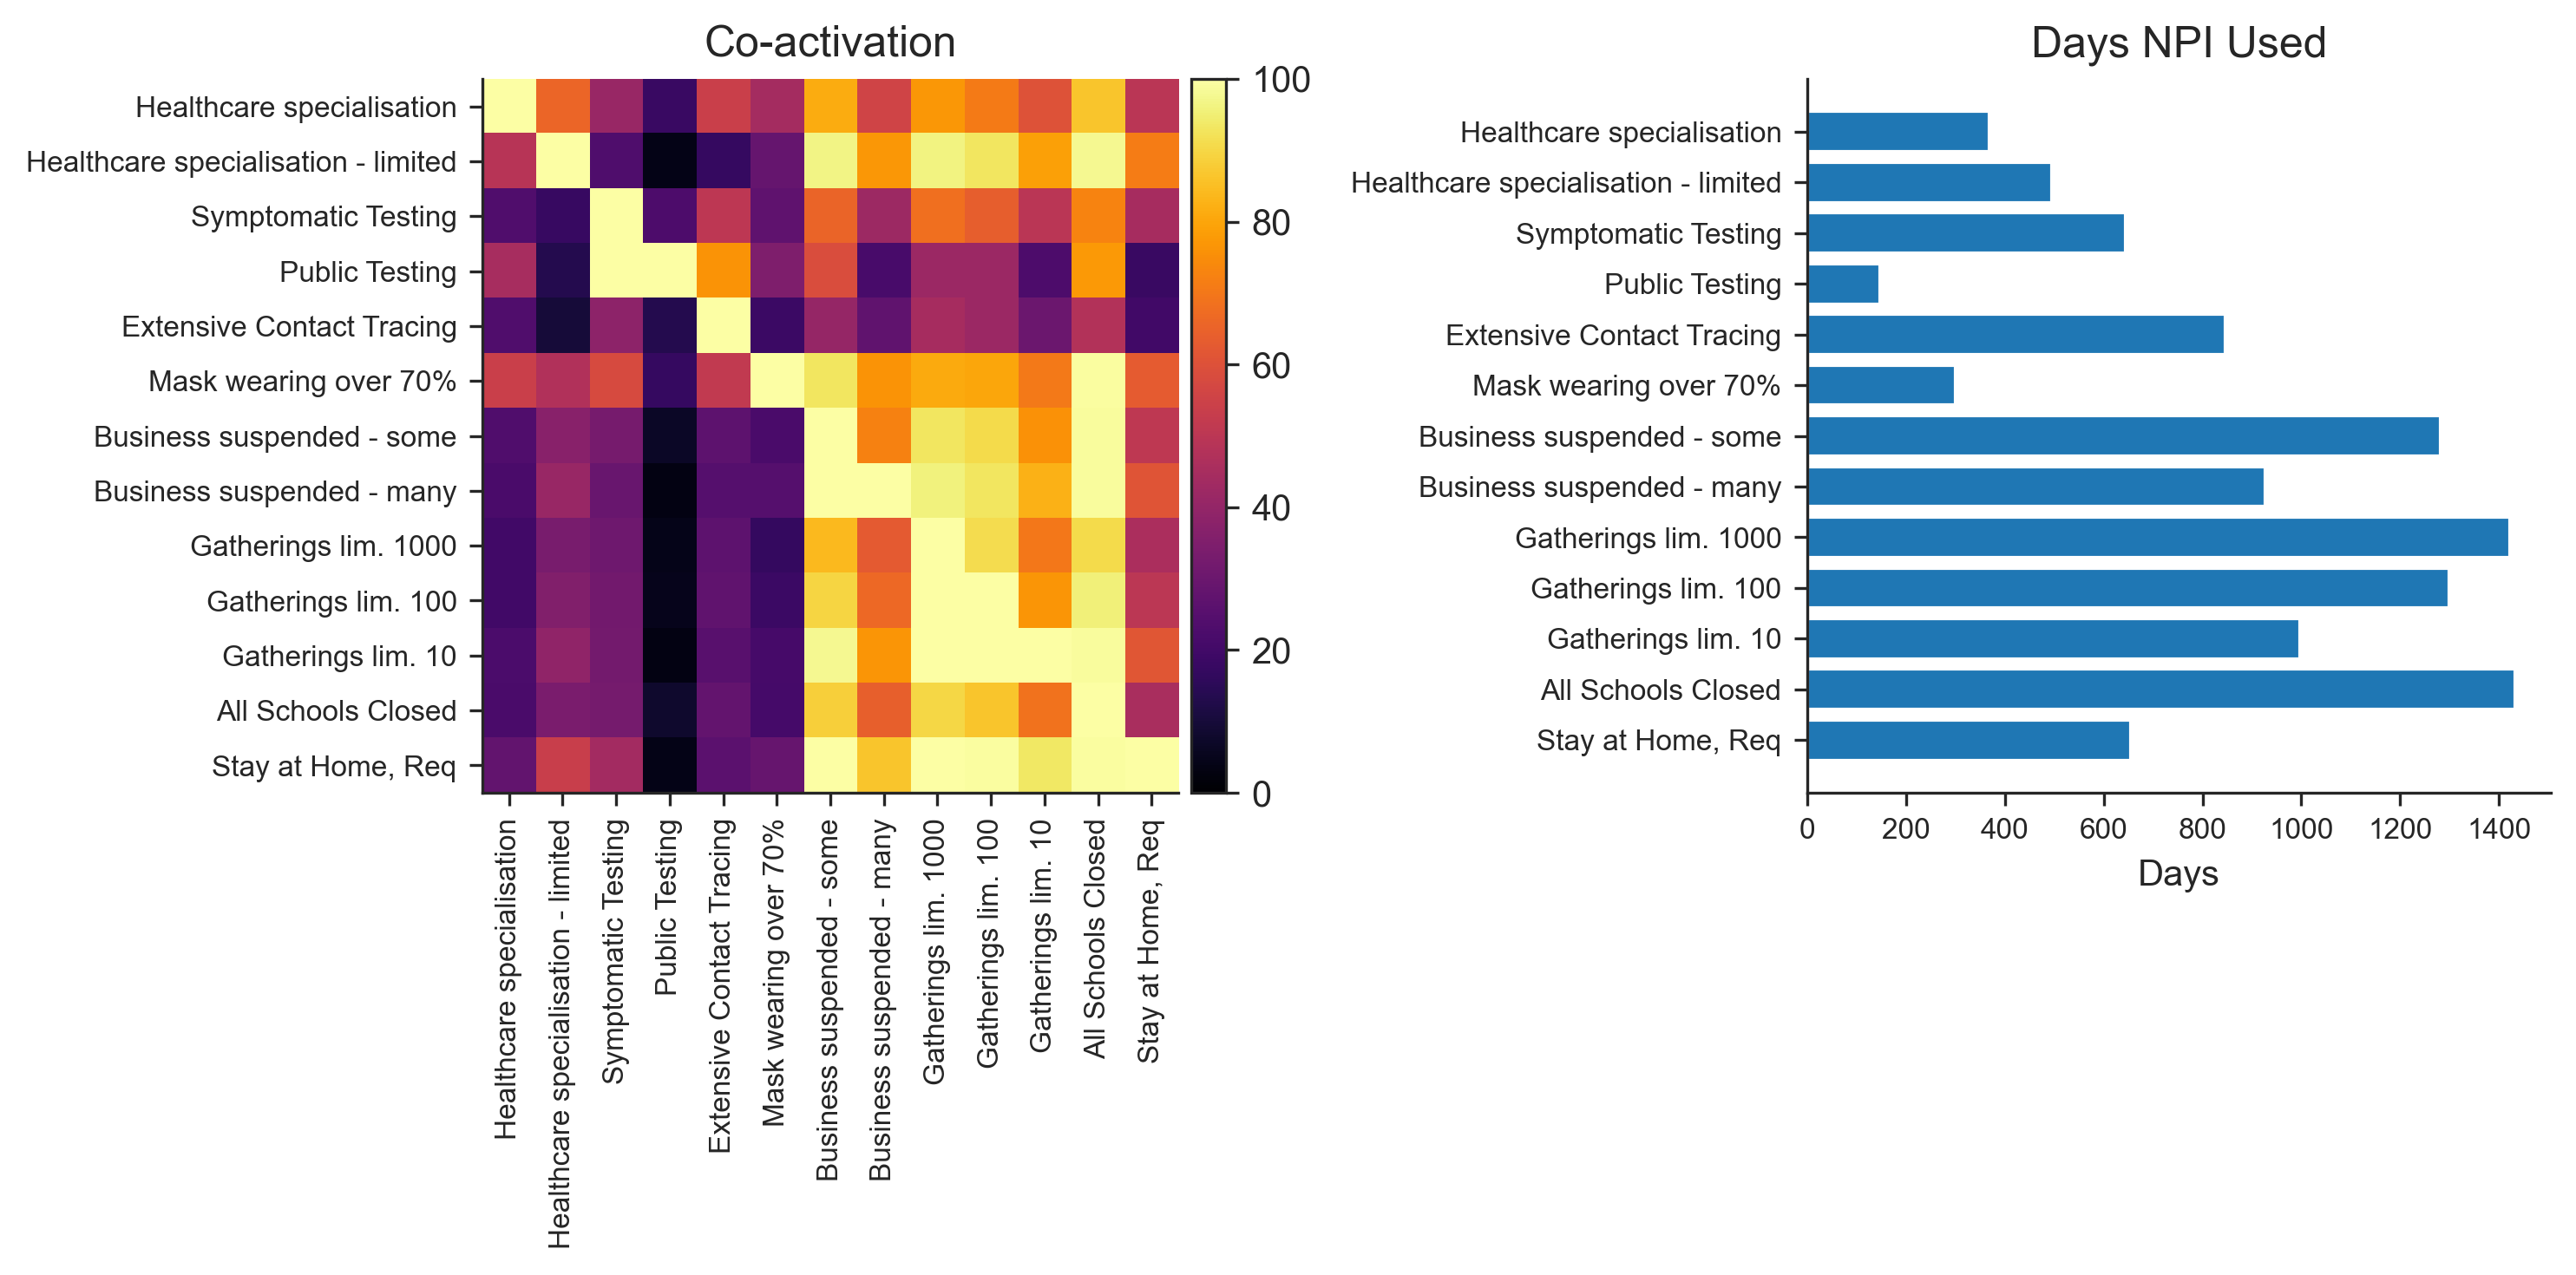

In [71]:
data = dp.preprocess_data("../../data", region_info, oxcgrt_filter, oxcgrt_cm_cols, 
                          epifor_features, final_features_ordered,ox_epi, epifor_end_date="2020-04-20")

In [72]:
ActiveCMs = data.ActiveCMs

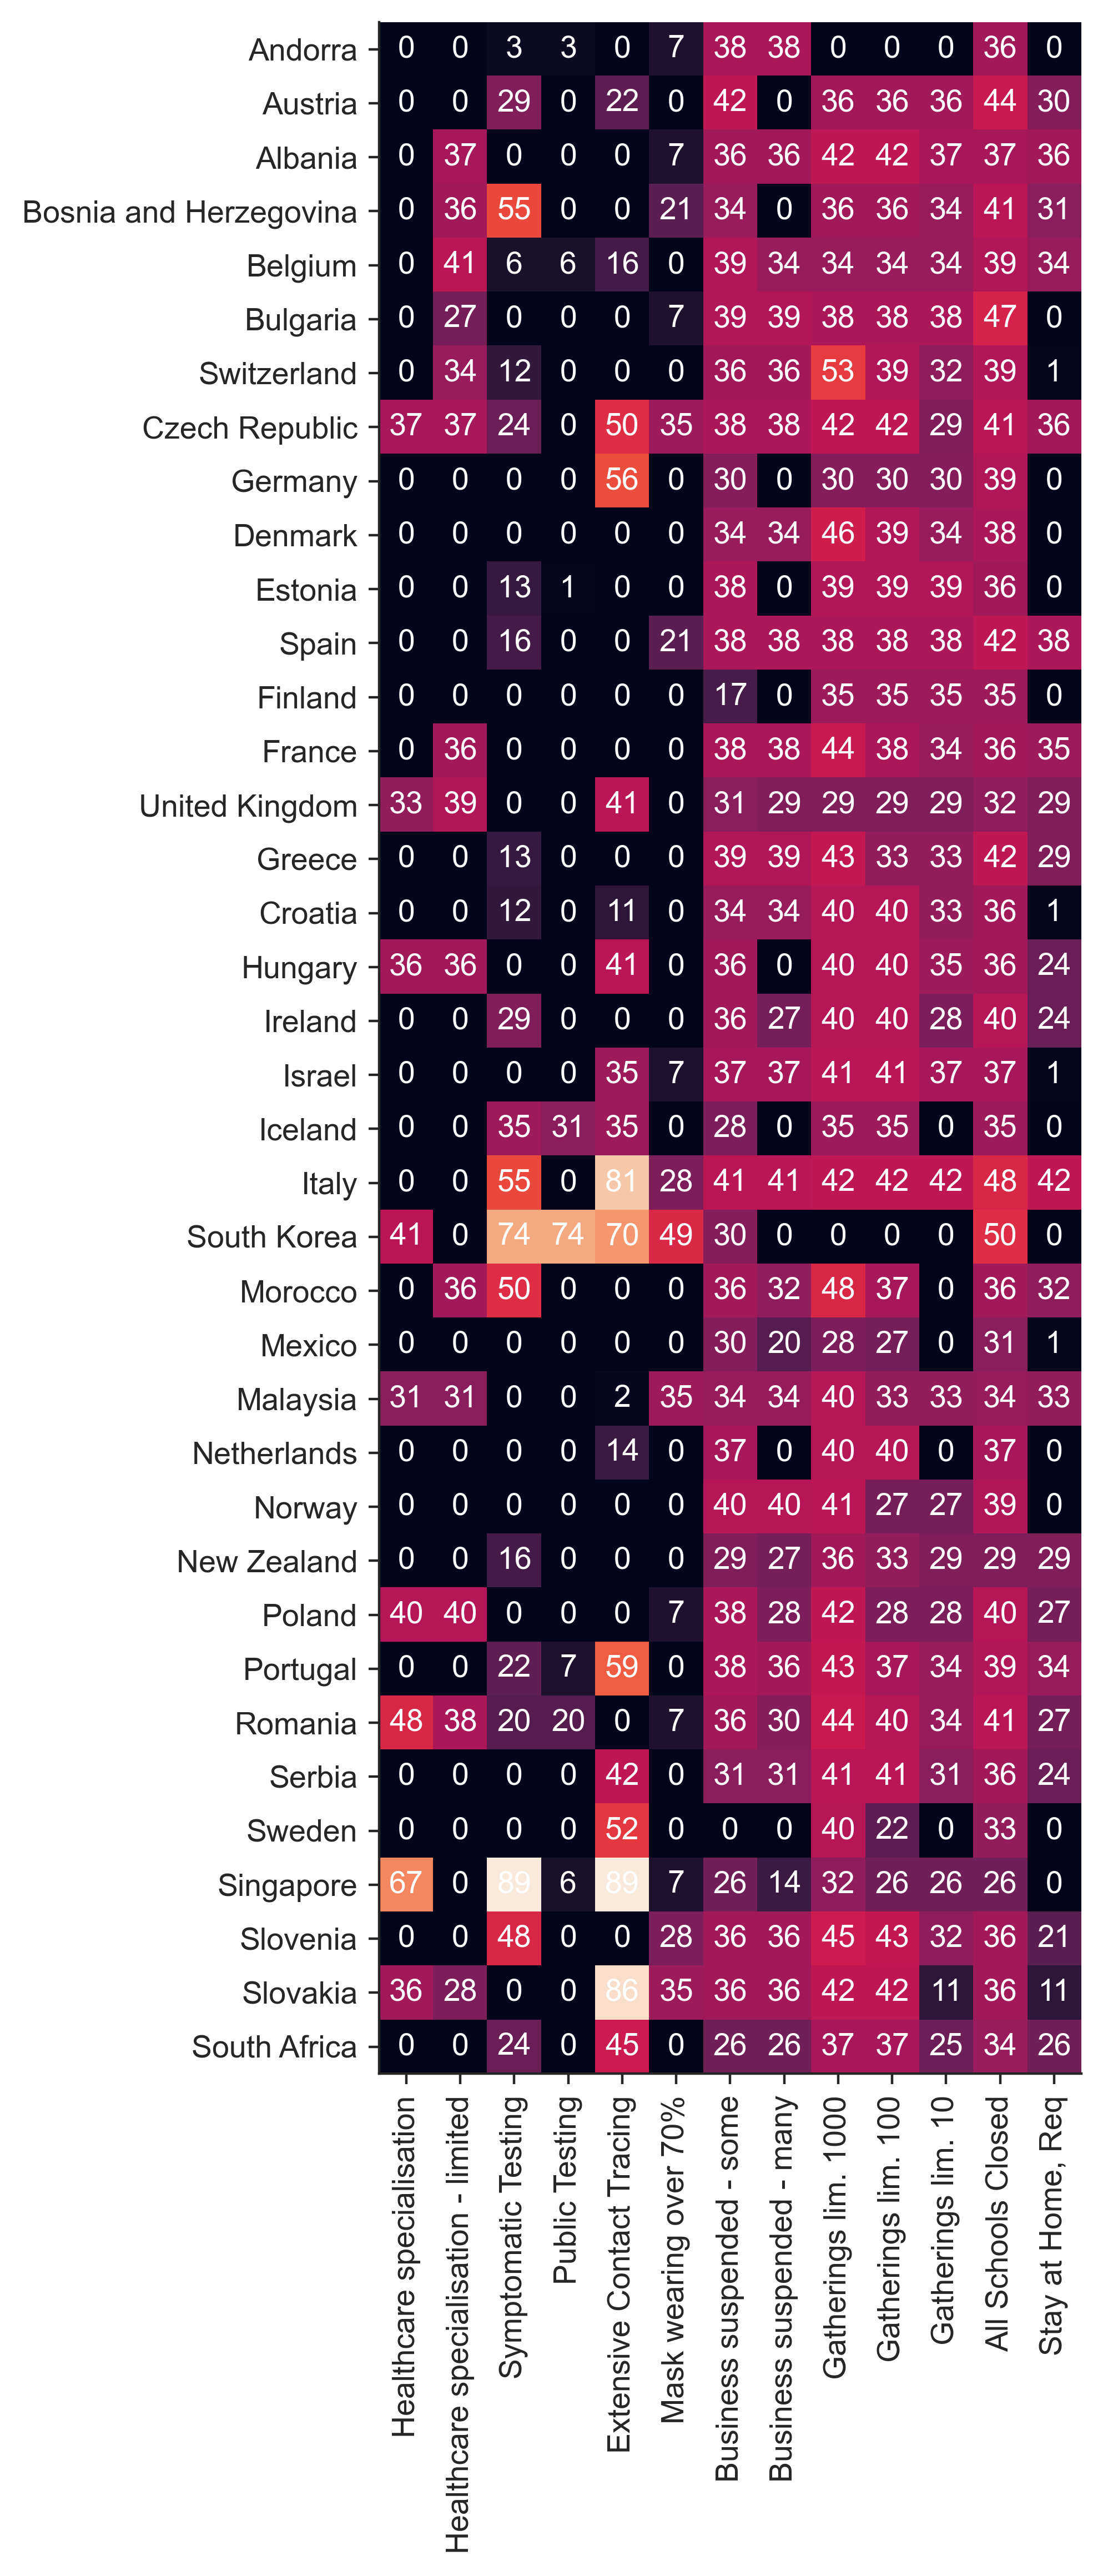

In [73]:
days_active_table = np.zeros(shape=(len(region_info), nCMs))
for d_indx, region in enumerate(region_info):
    for indx, f in enumerate(final_features_ordered):
        days_active_table[d_indx, indx] = np.sum(ActiveCMs[d_indx, indx, :])

fig = plt.figure(figsize=(8.3, 11.7), dpi=400)
plt.imshow(days_active_table)

for r in range(len(region_info)):
    for cm in range(len(final_features_ordered)):
        num = days_active_table[r, cm]
        if num < 90:
            plt.text(cm, r, f"{num:.0f}", color="white", horizontalalignment="center", verticalalignment="center")
        else:
            plt.text(cm, r, f"{num:.0f}", color="black", horizontalalignment="center", verticalalignment="center")

plt.yticks(np.arange(len(region_names)), region_names)
plt.xticks(
    np.arange(len(final_features_ordered)),
    [f for f in final_features_ordered],
    rotation=90
)
sns.despine()
plt.ylim([len(region_info)-0.5, -0.5])
plt.tight_layout()
plt.savefig("table.pdf")

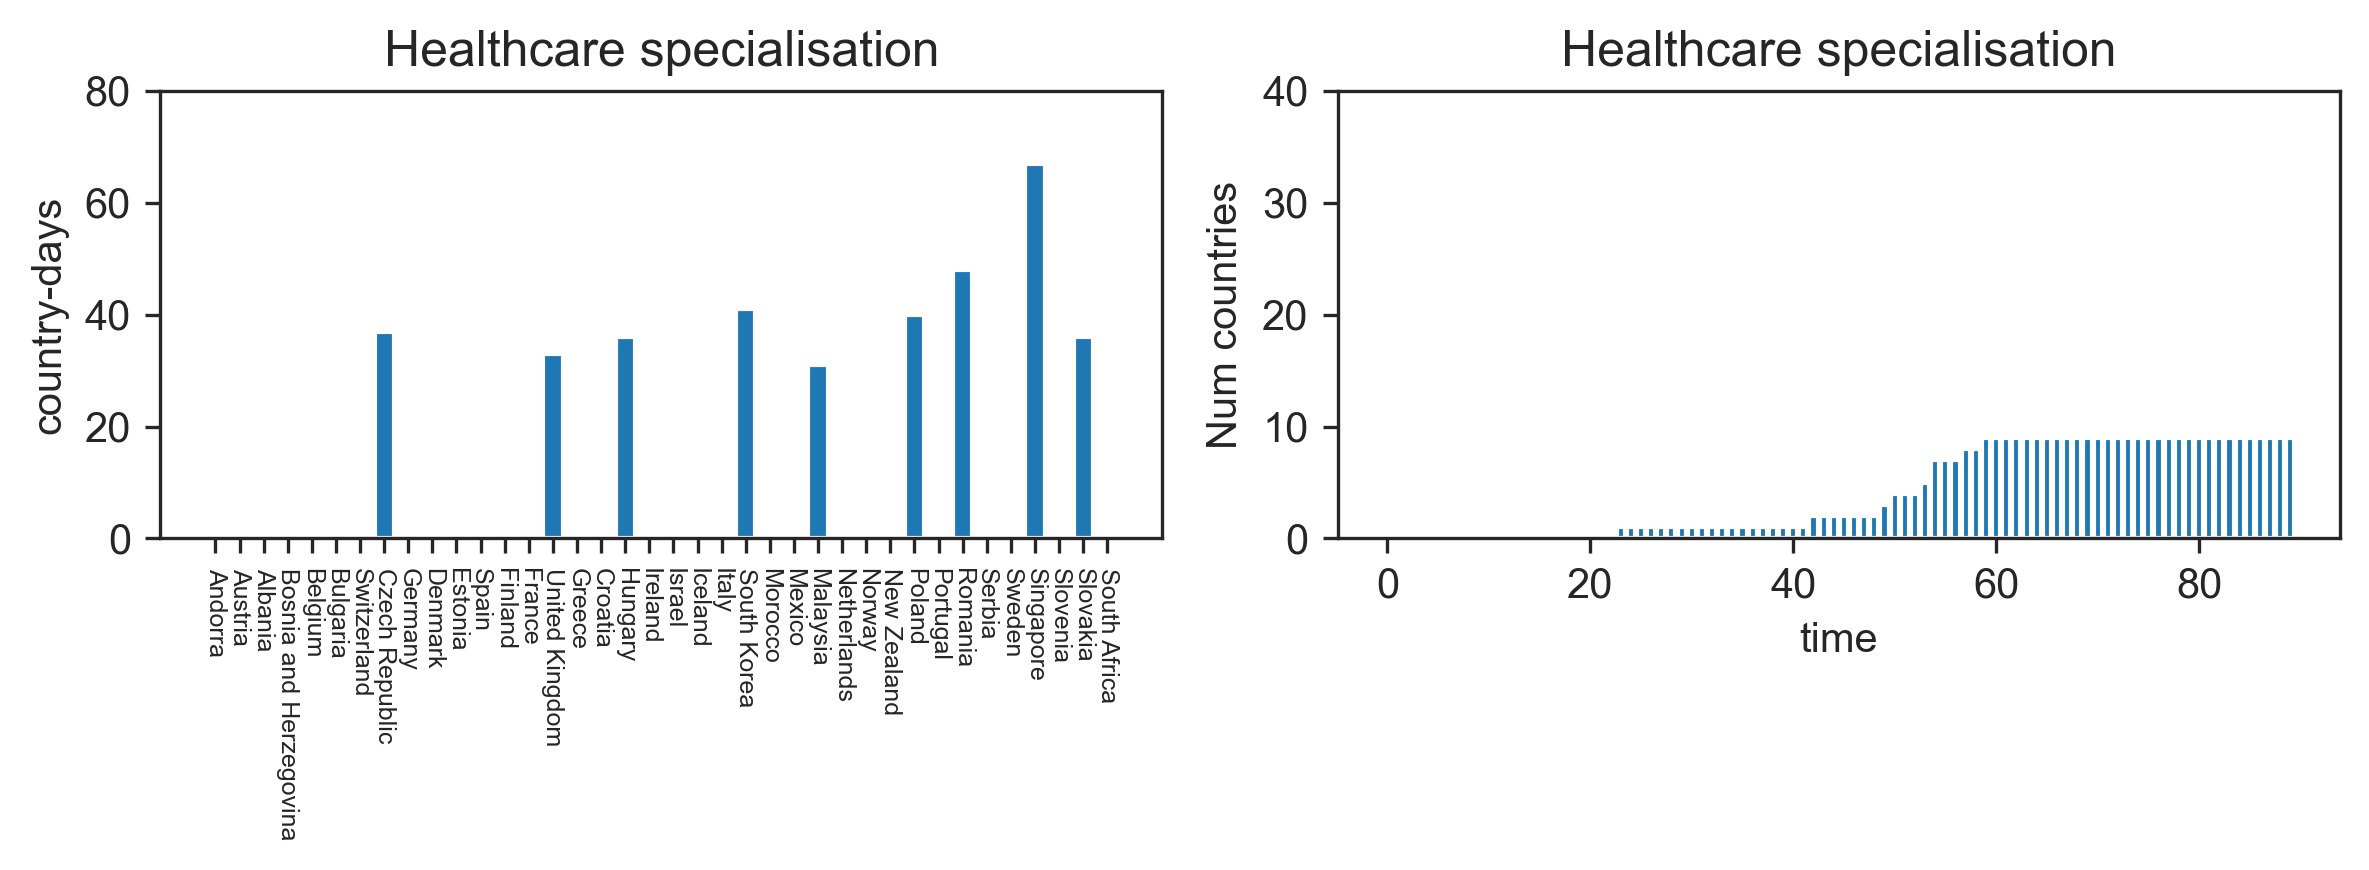

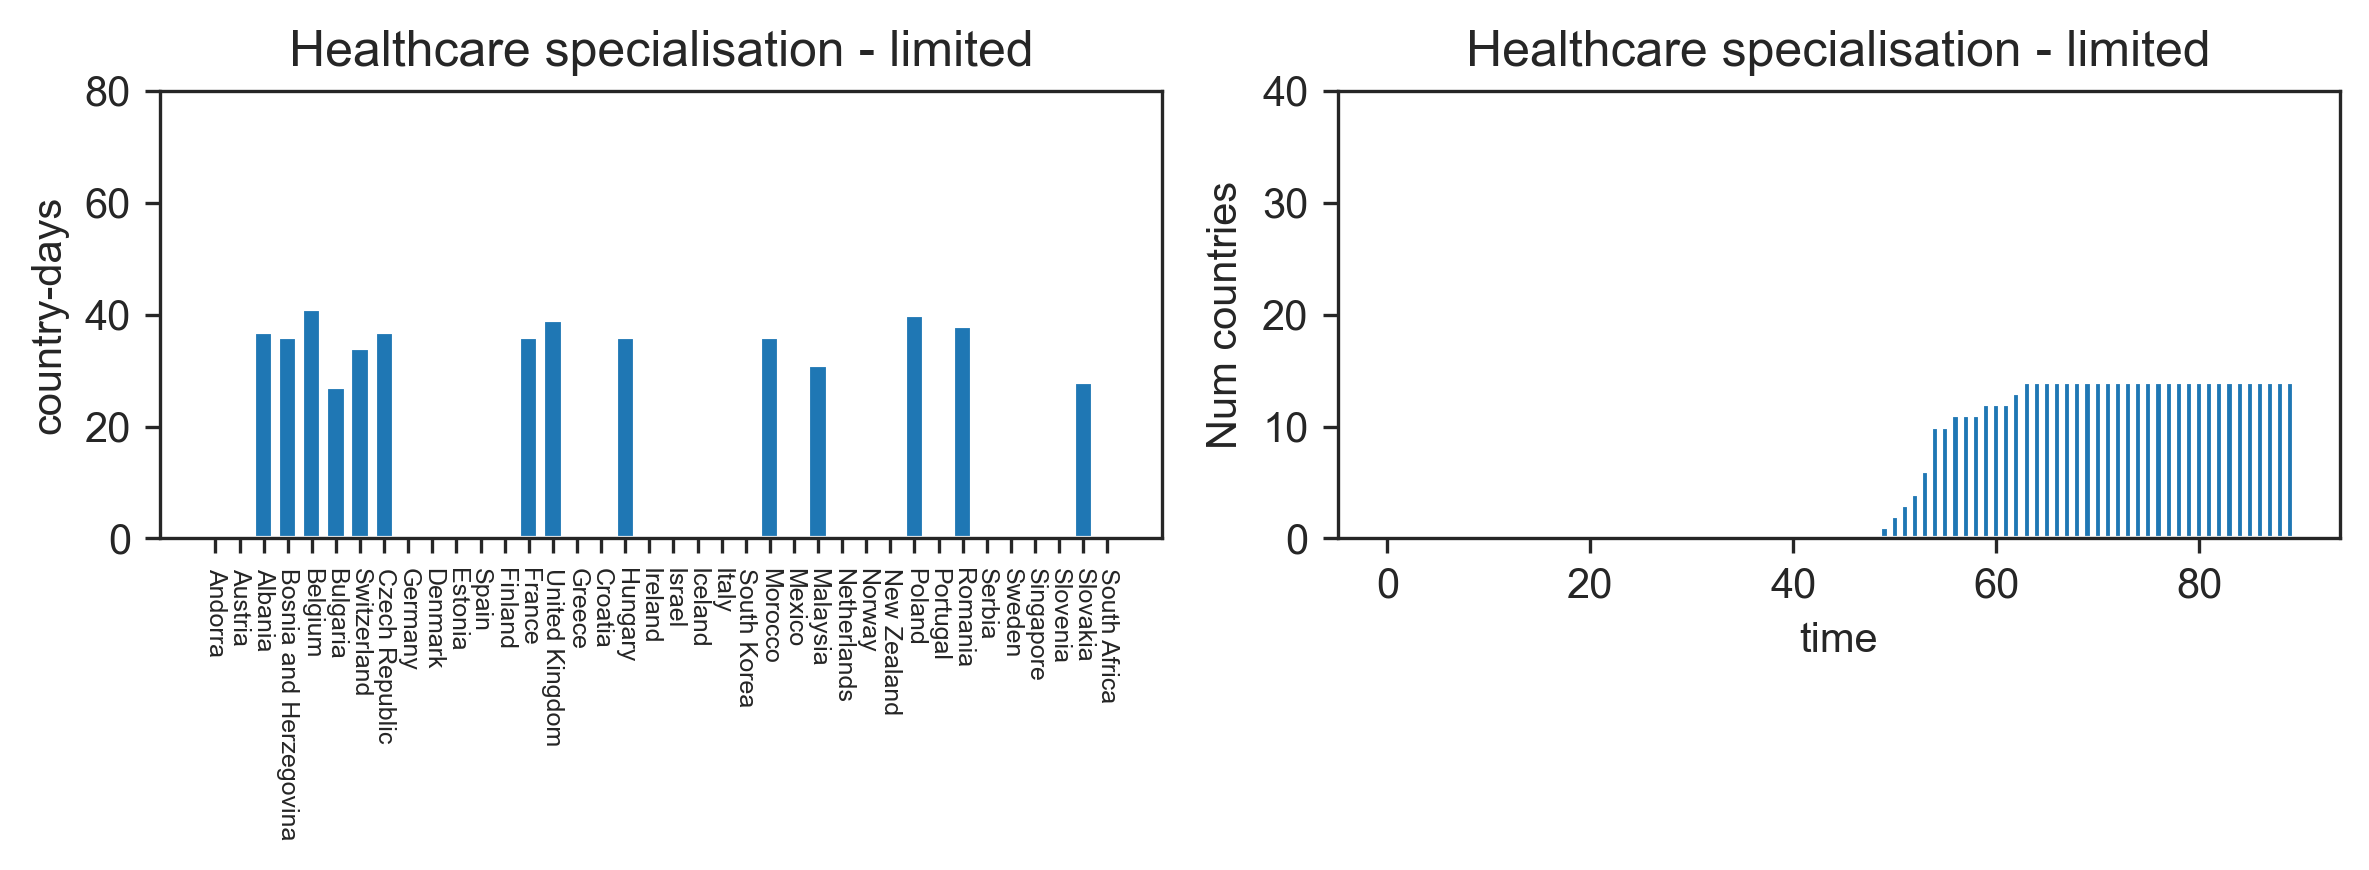

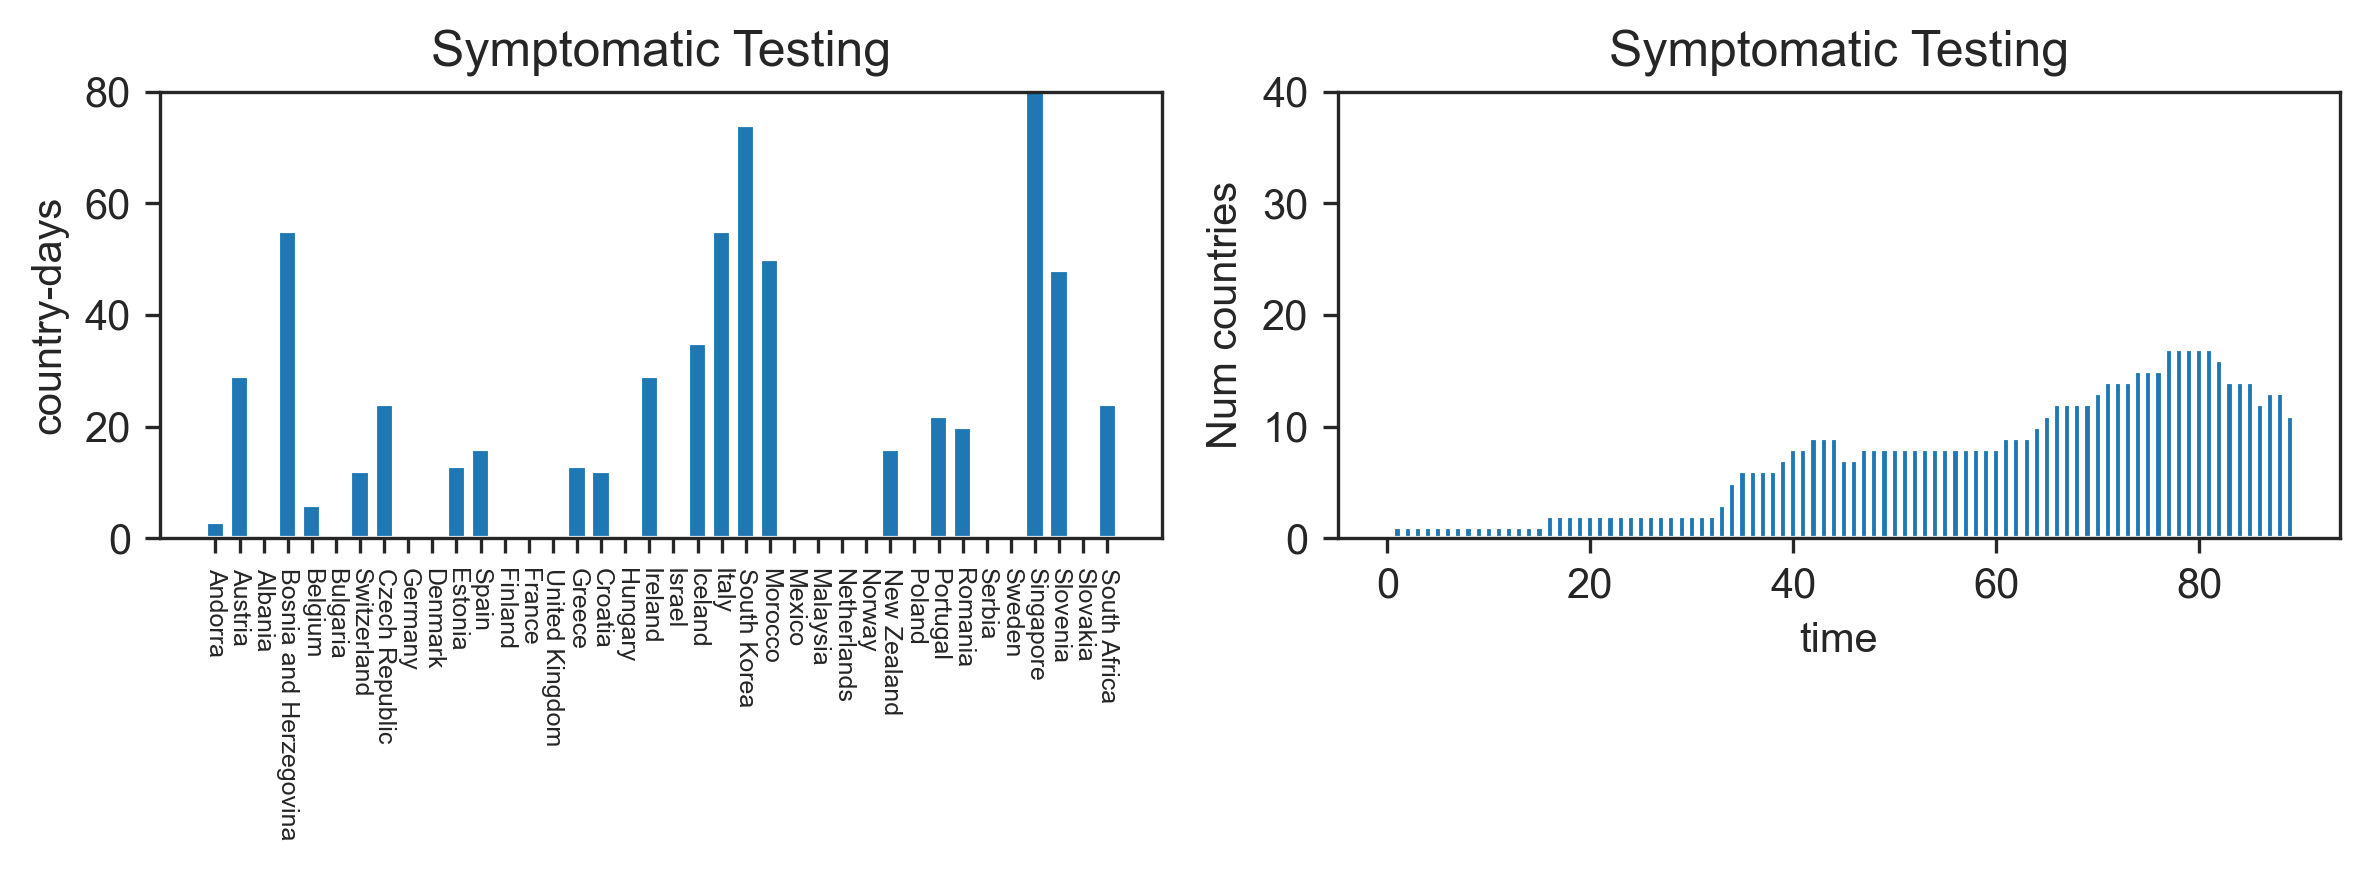

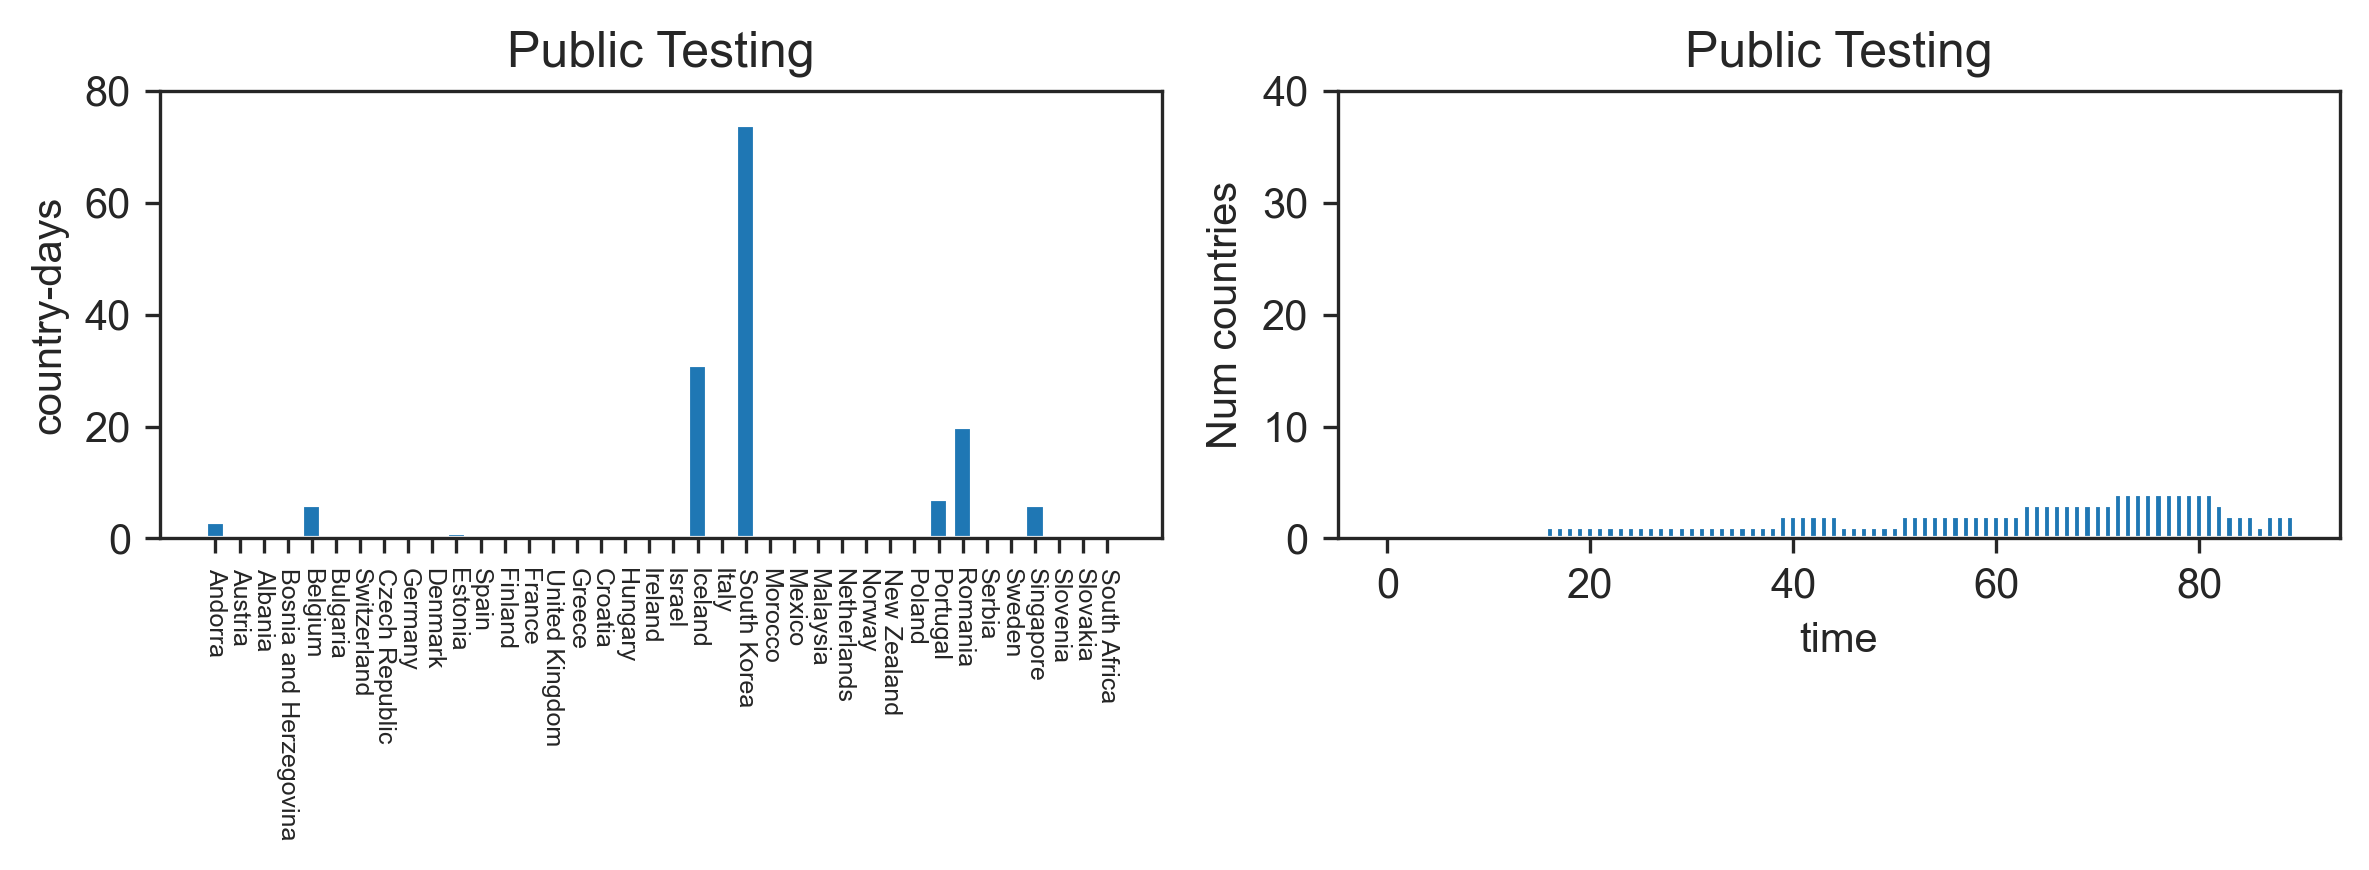

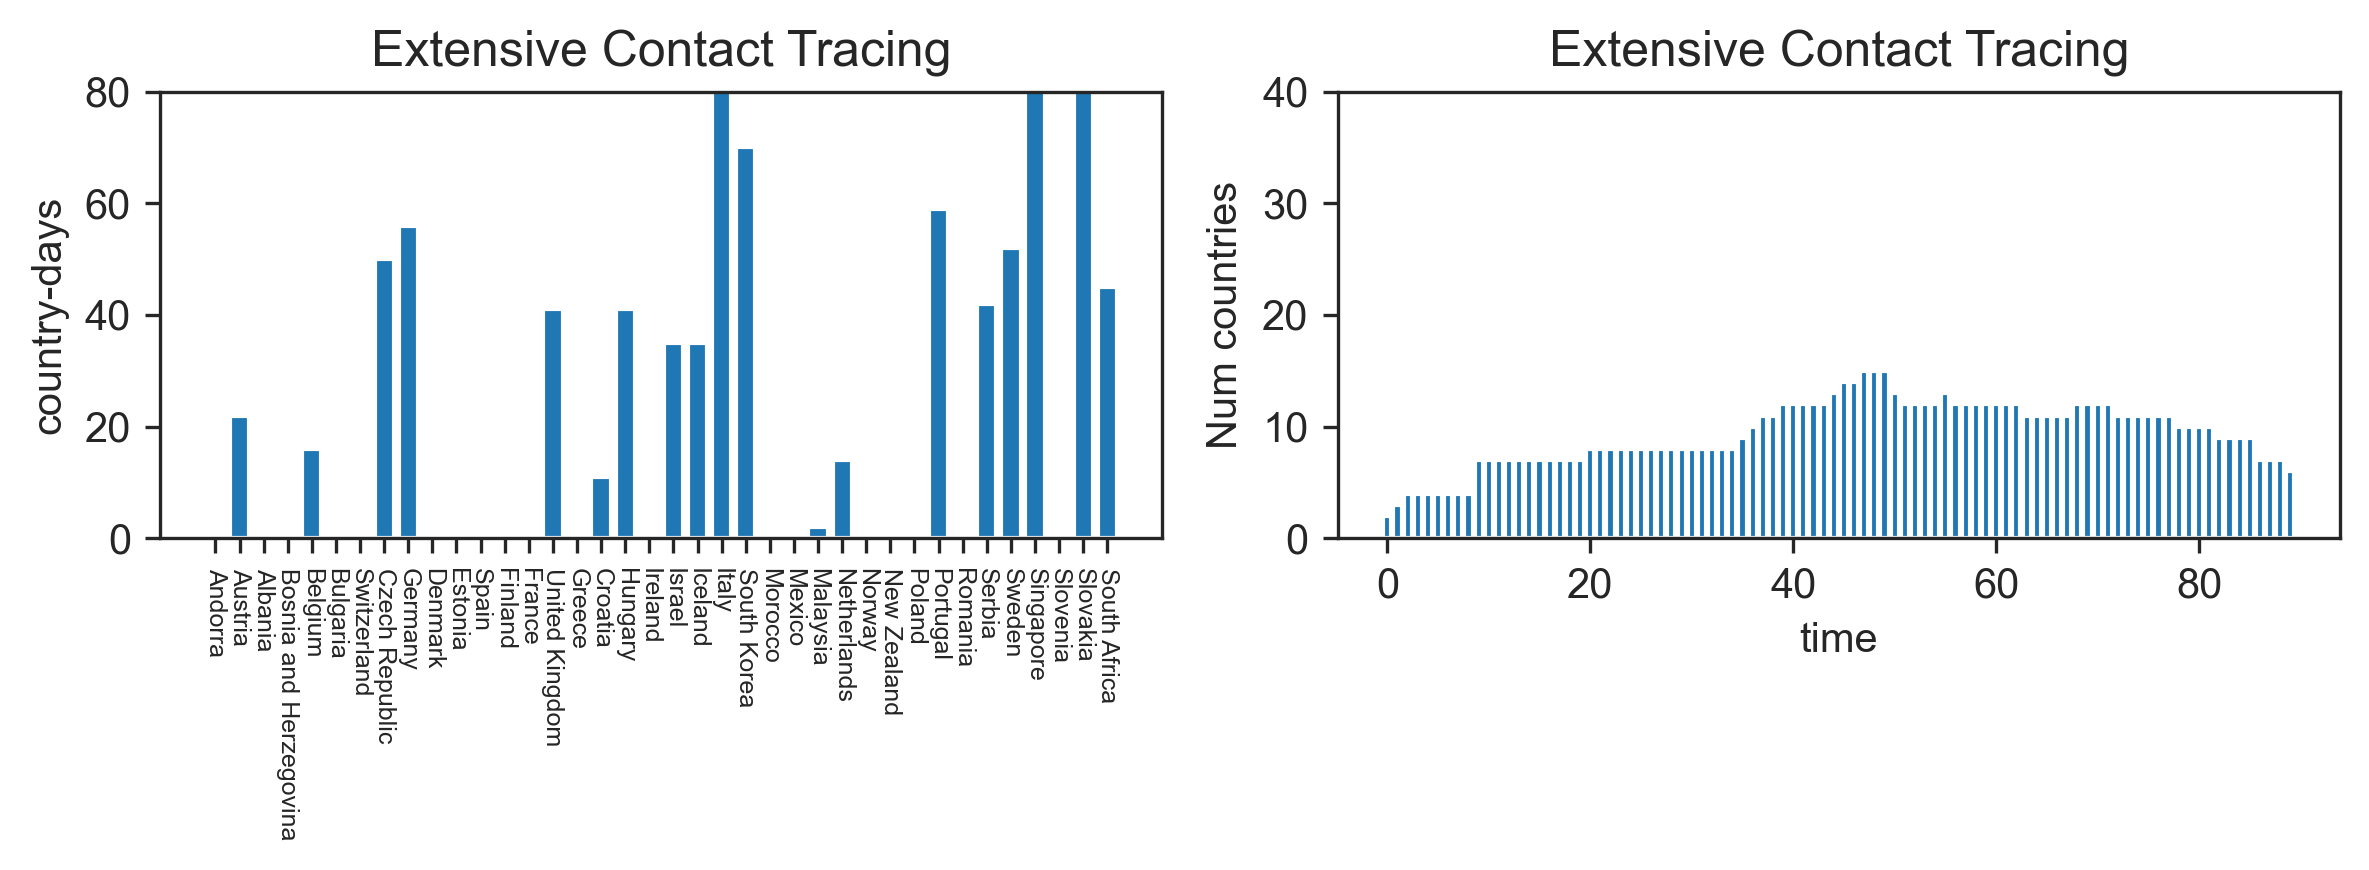

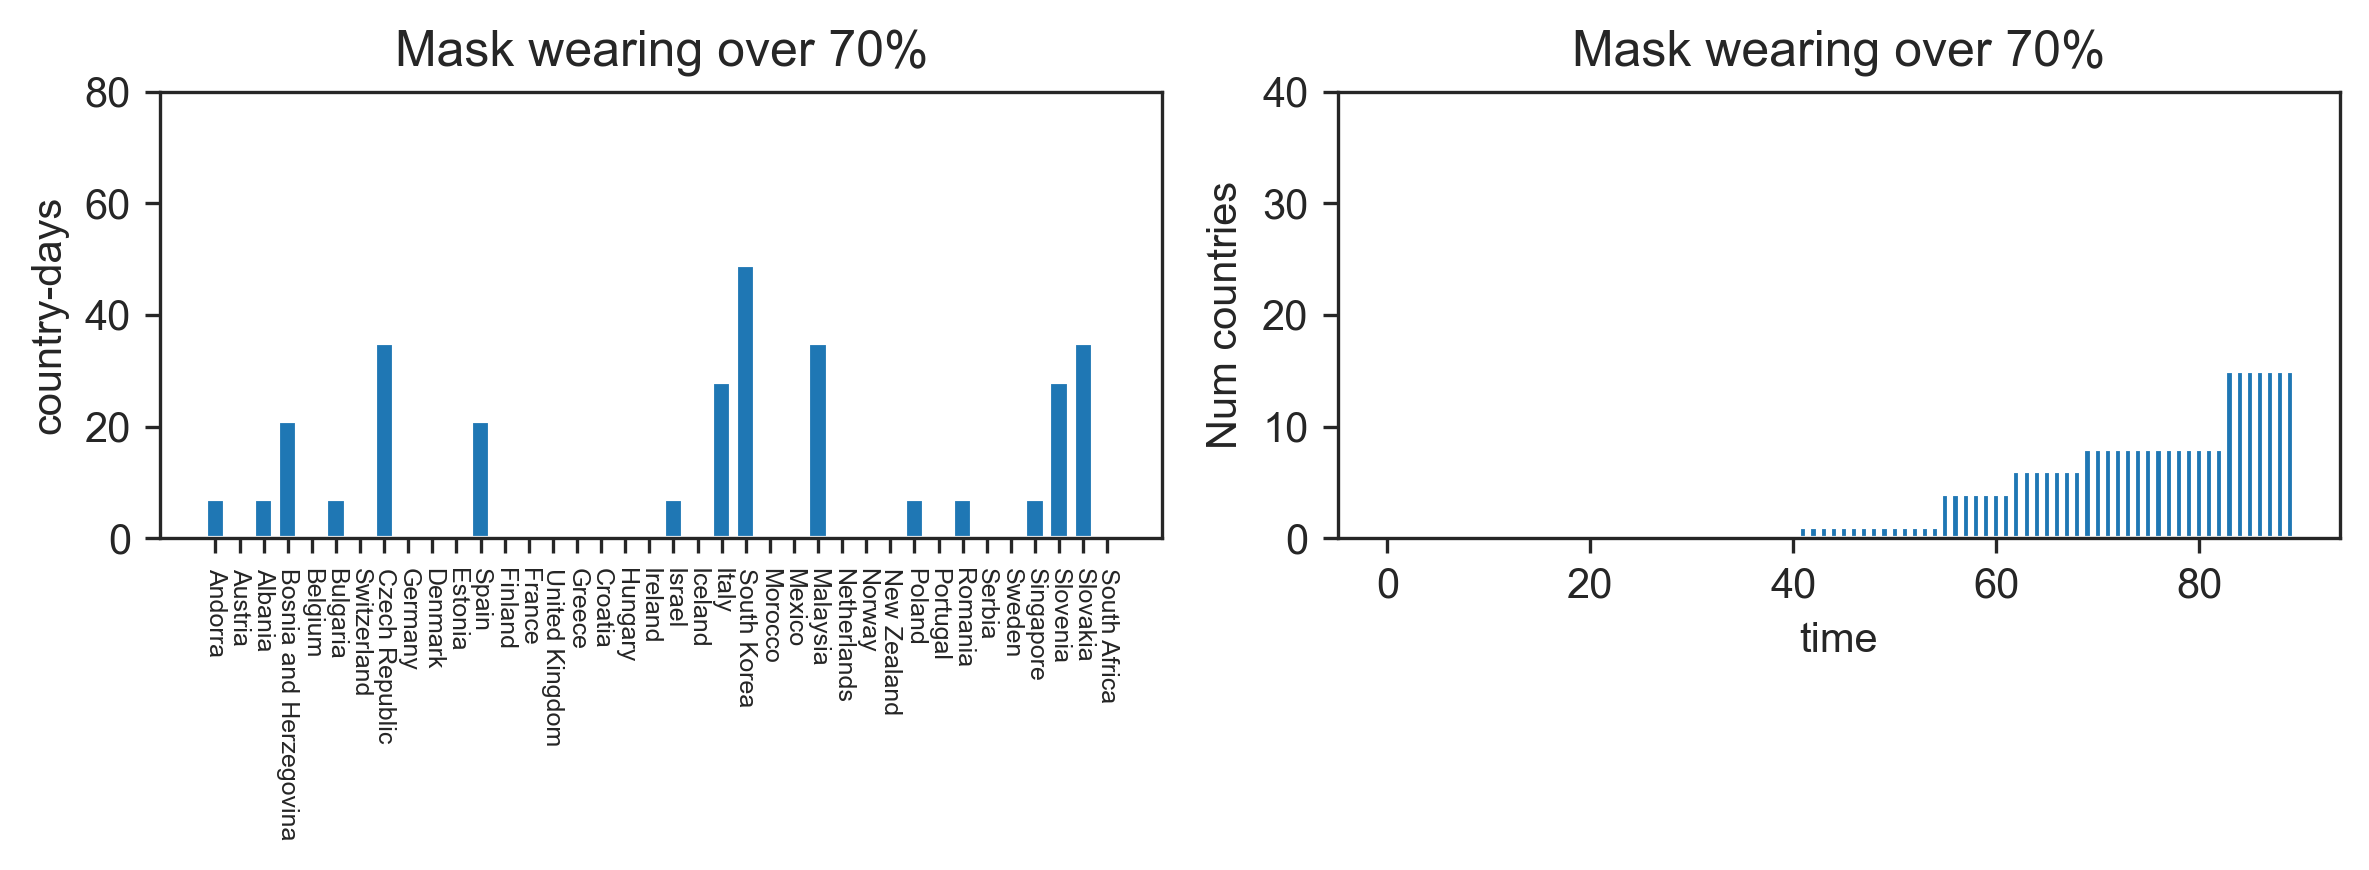

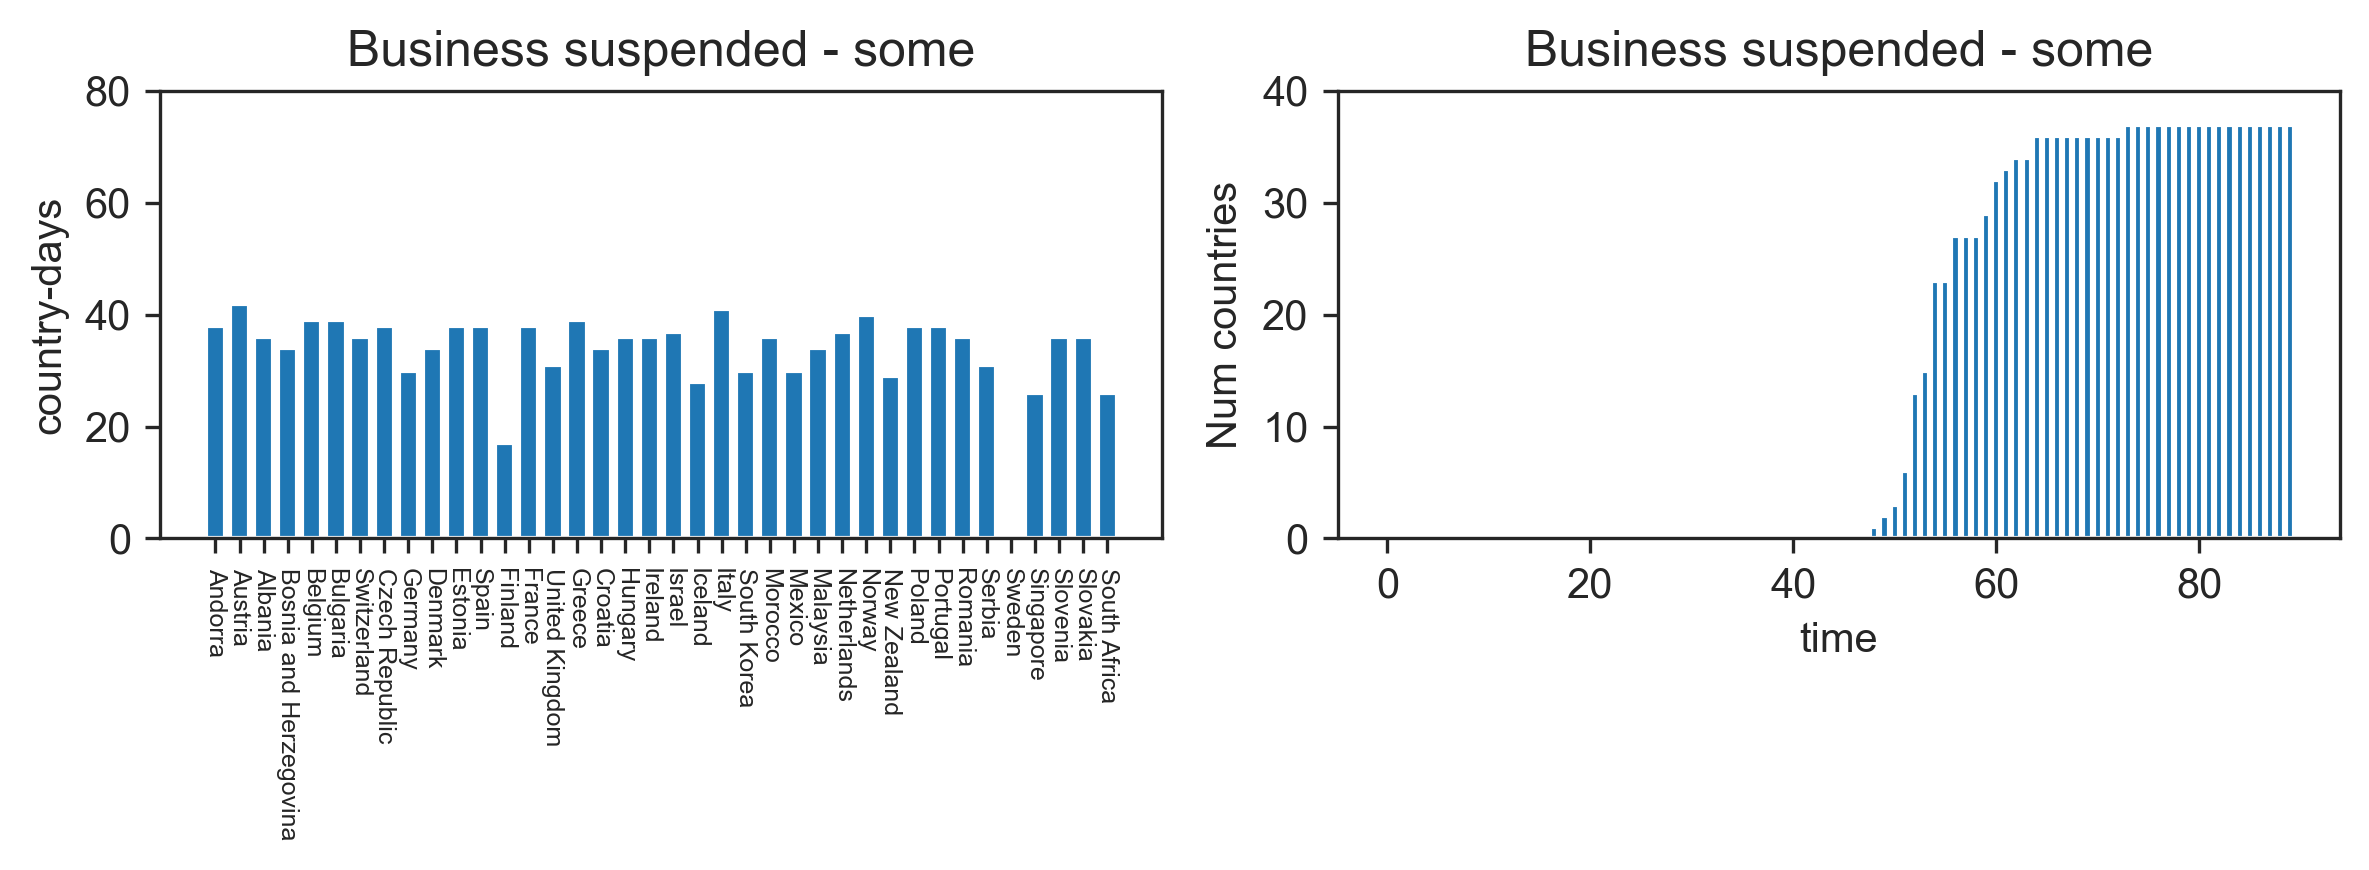

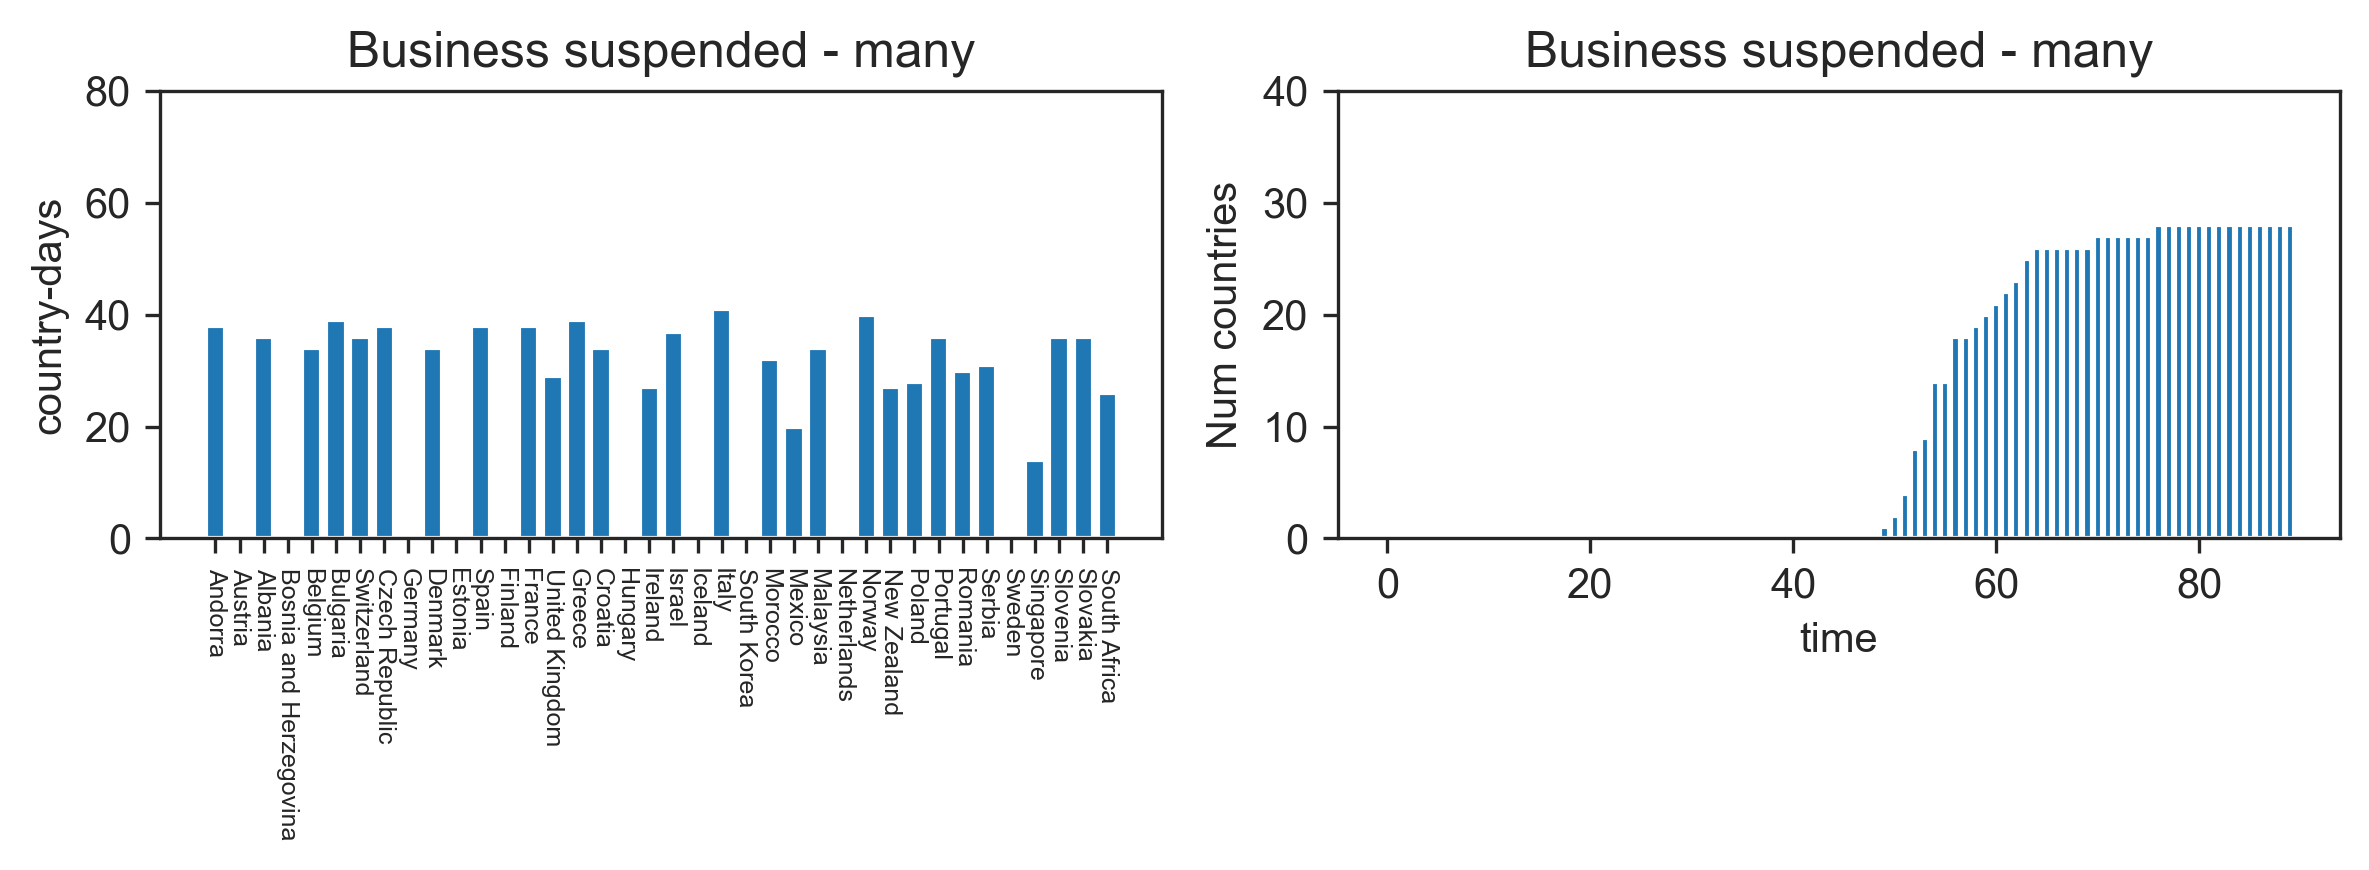

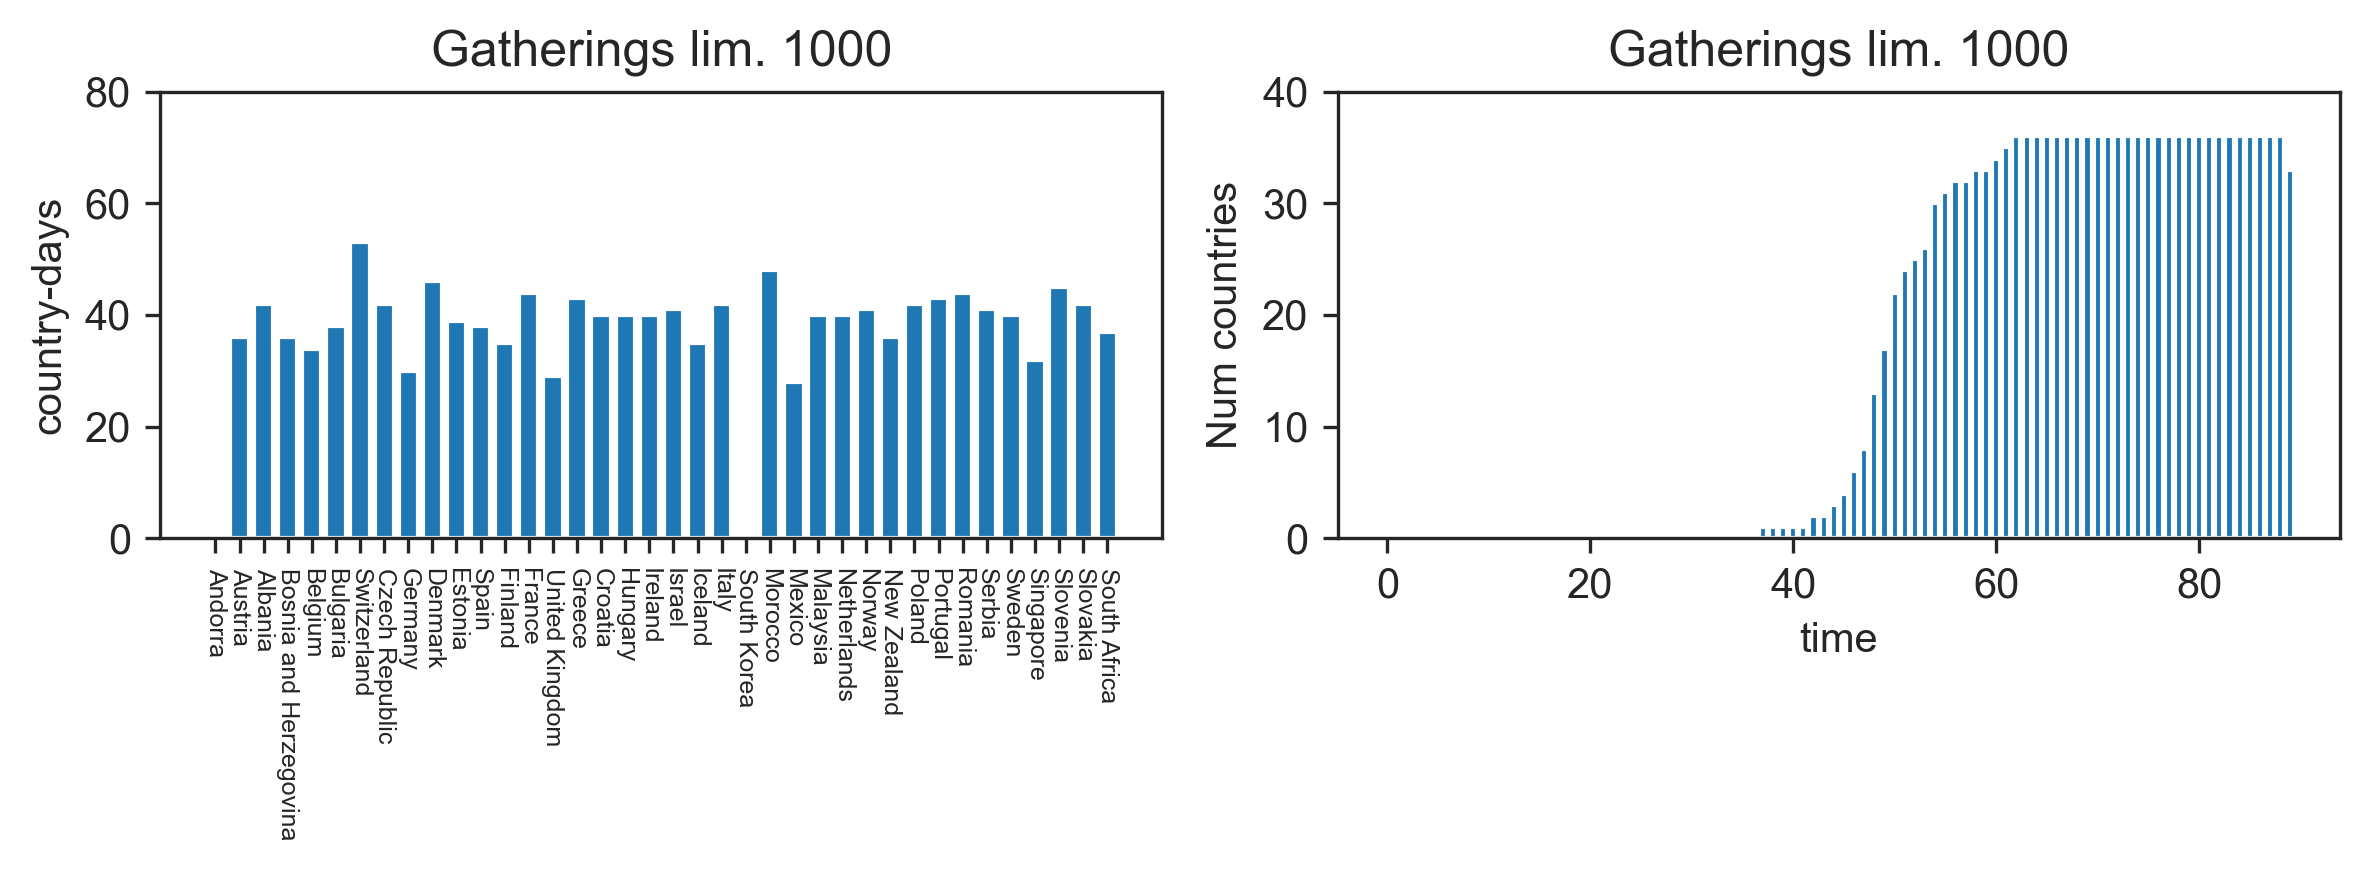

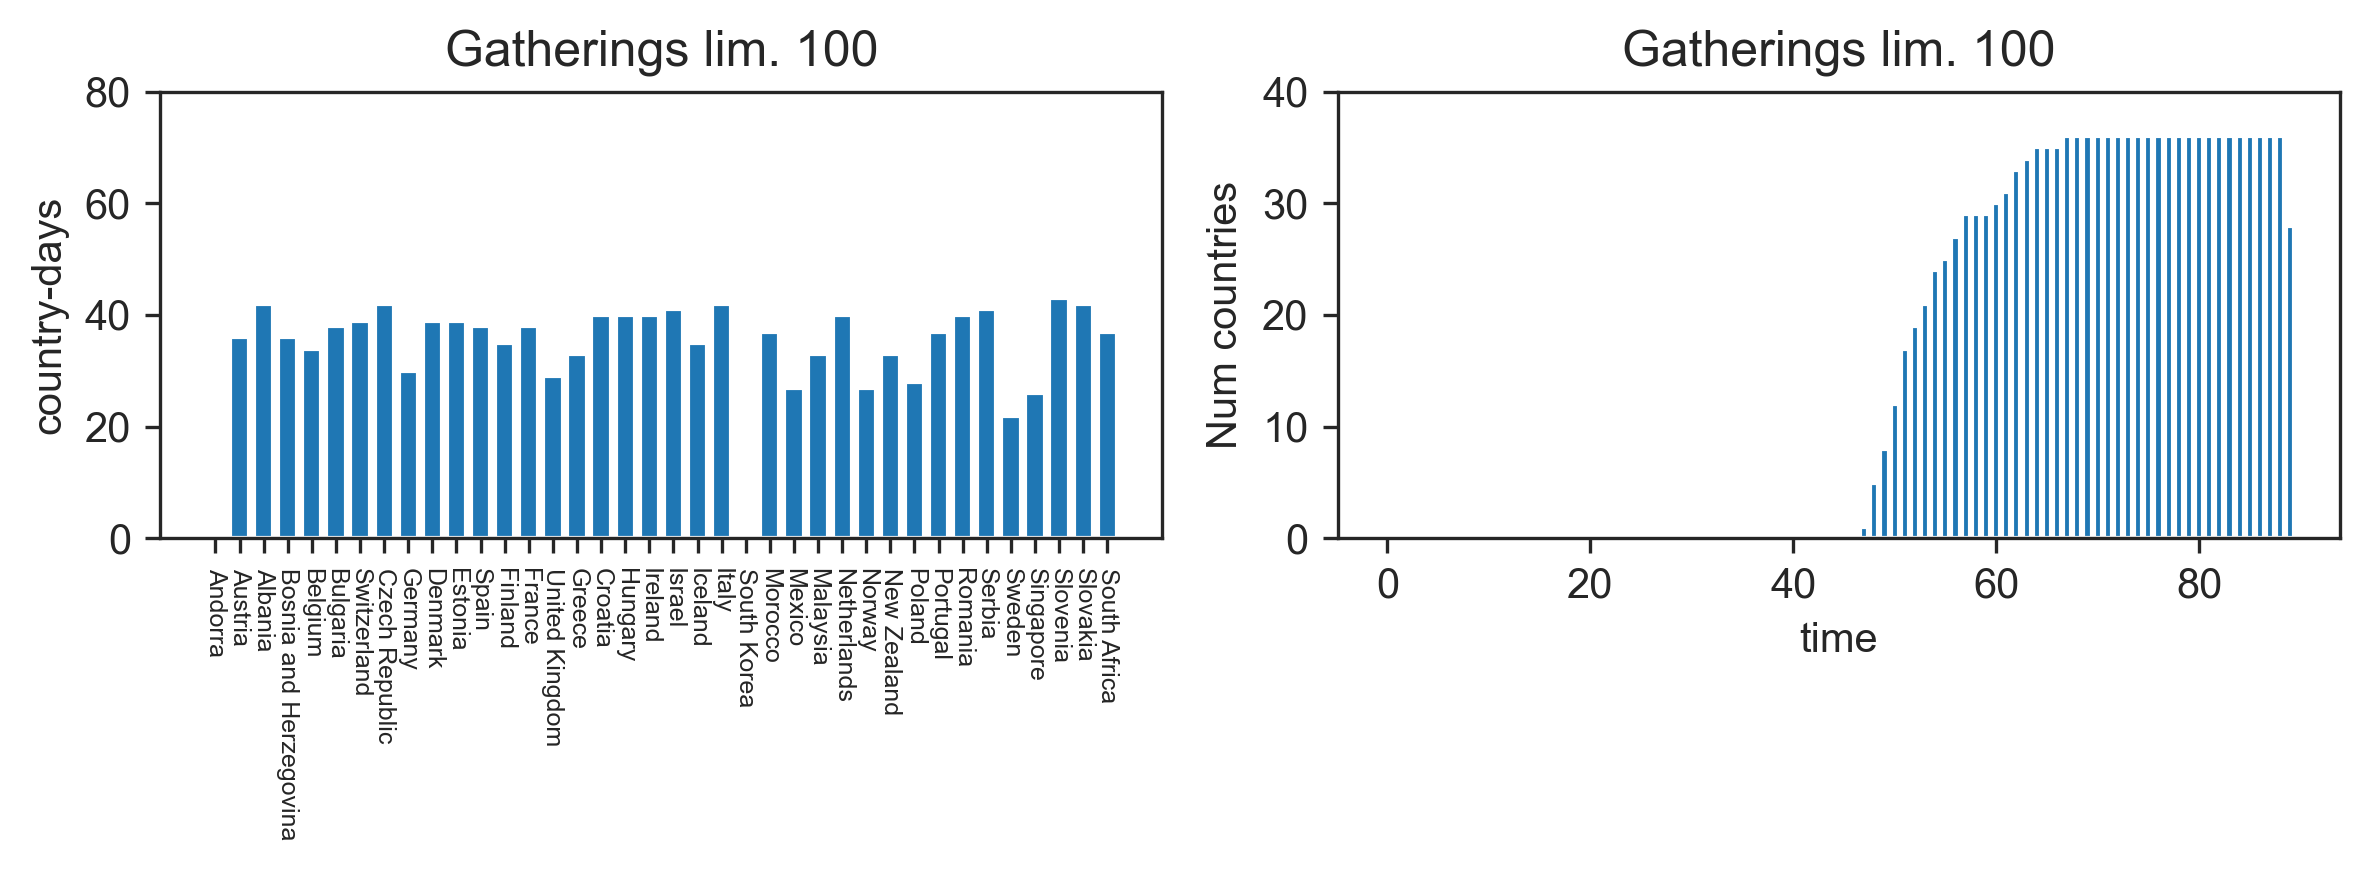

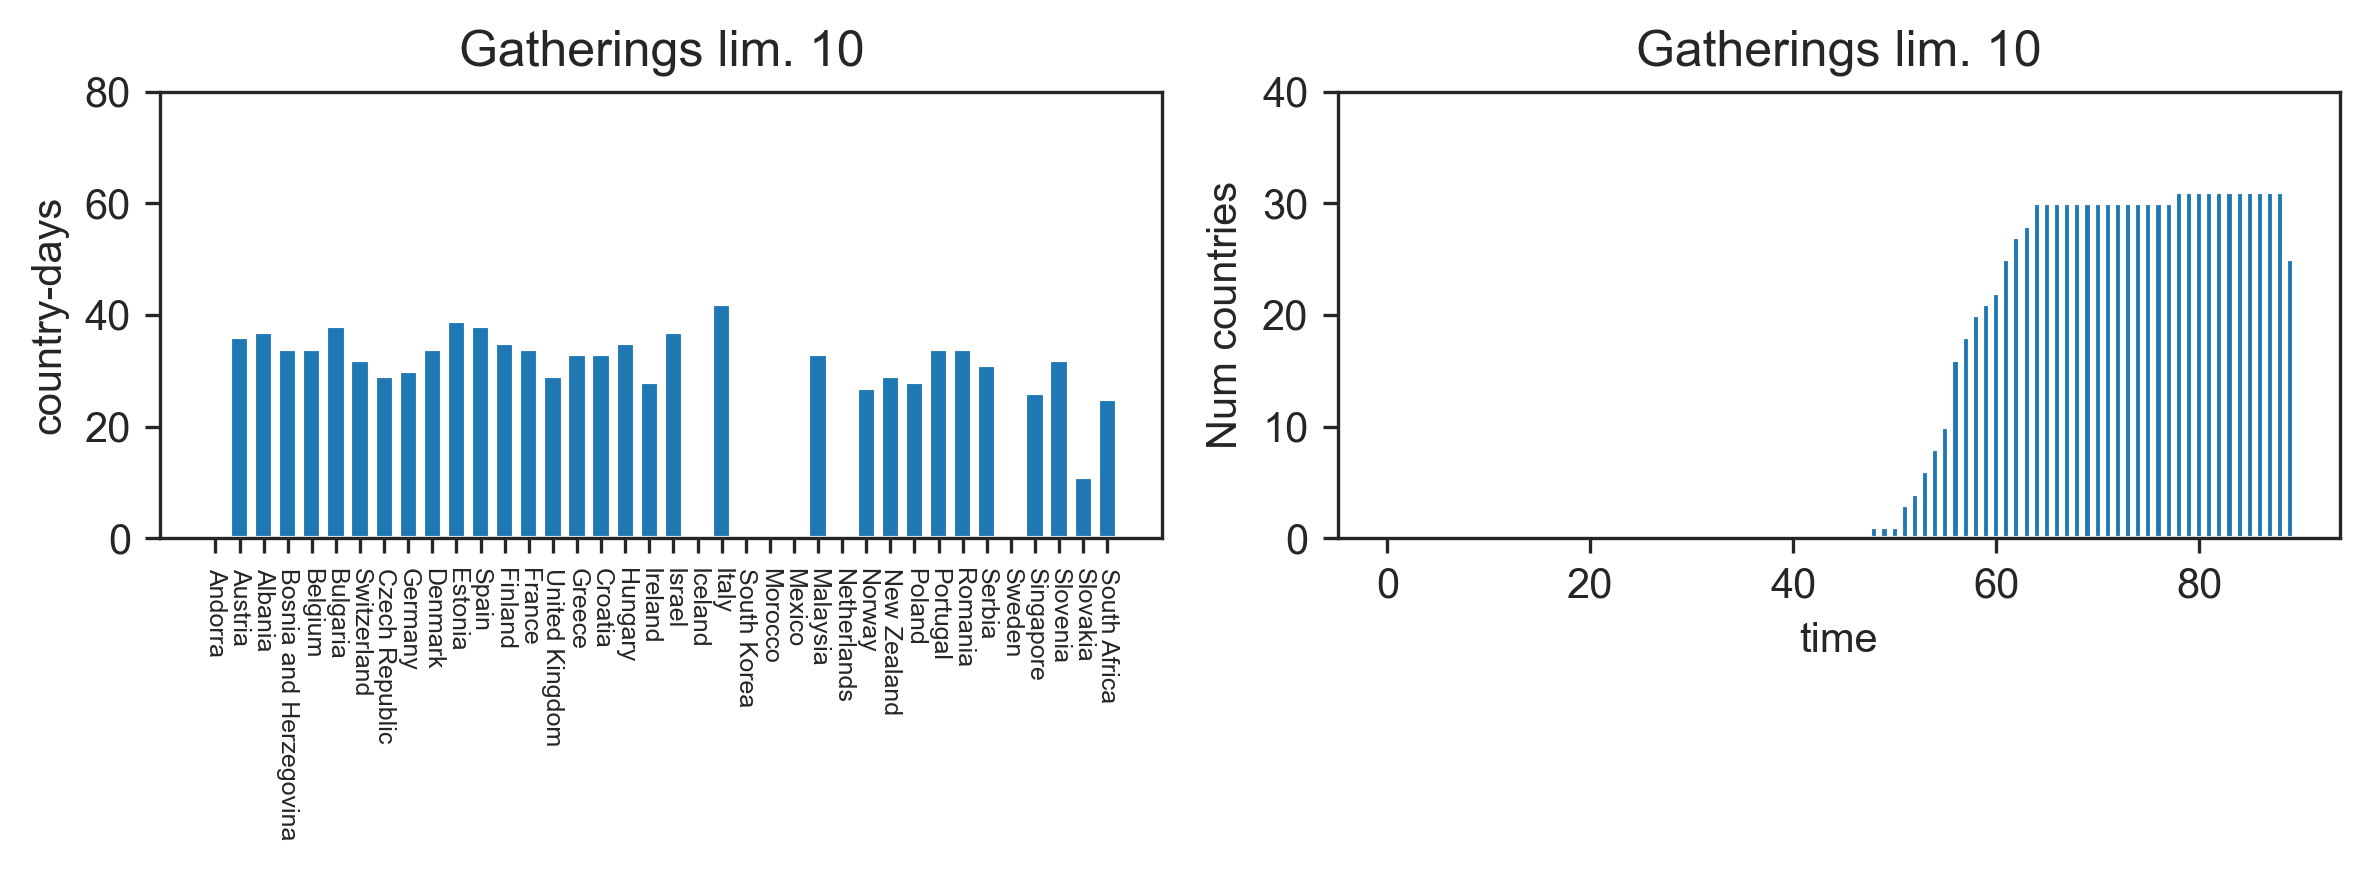

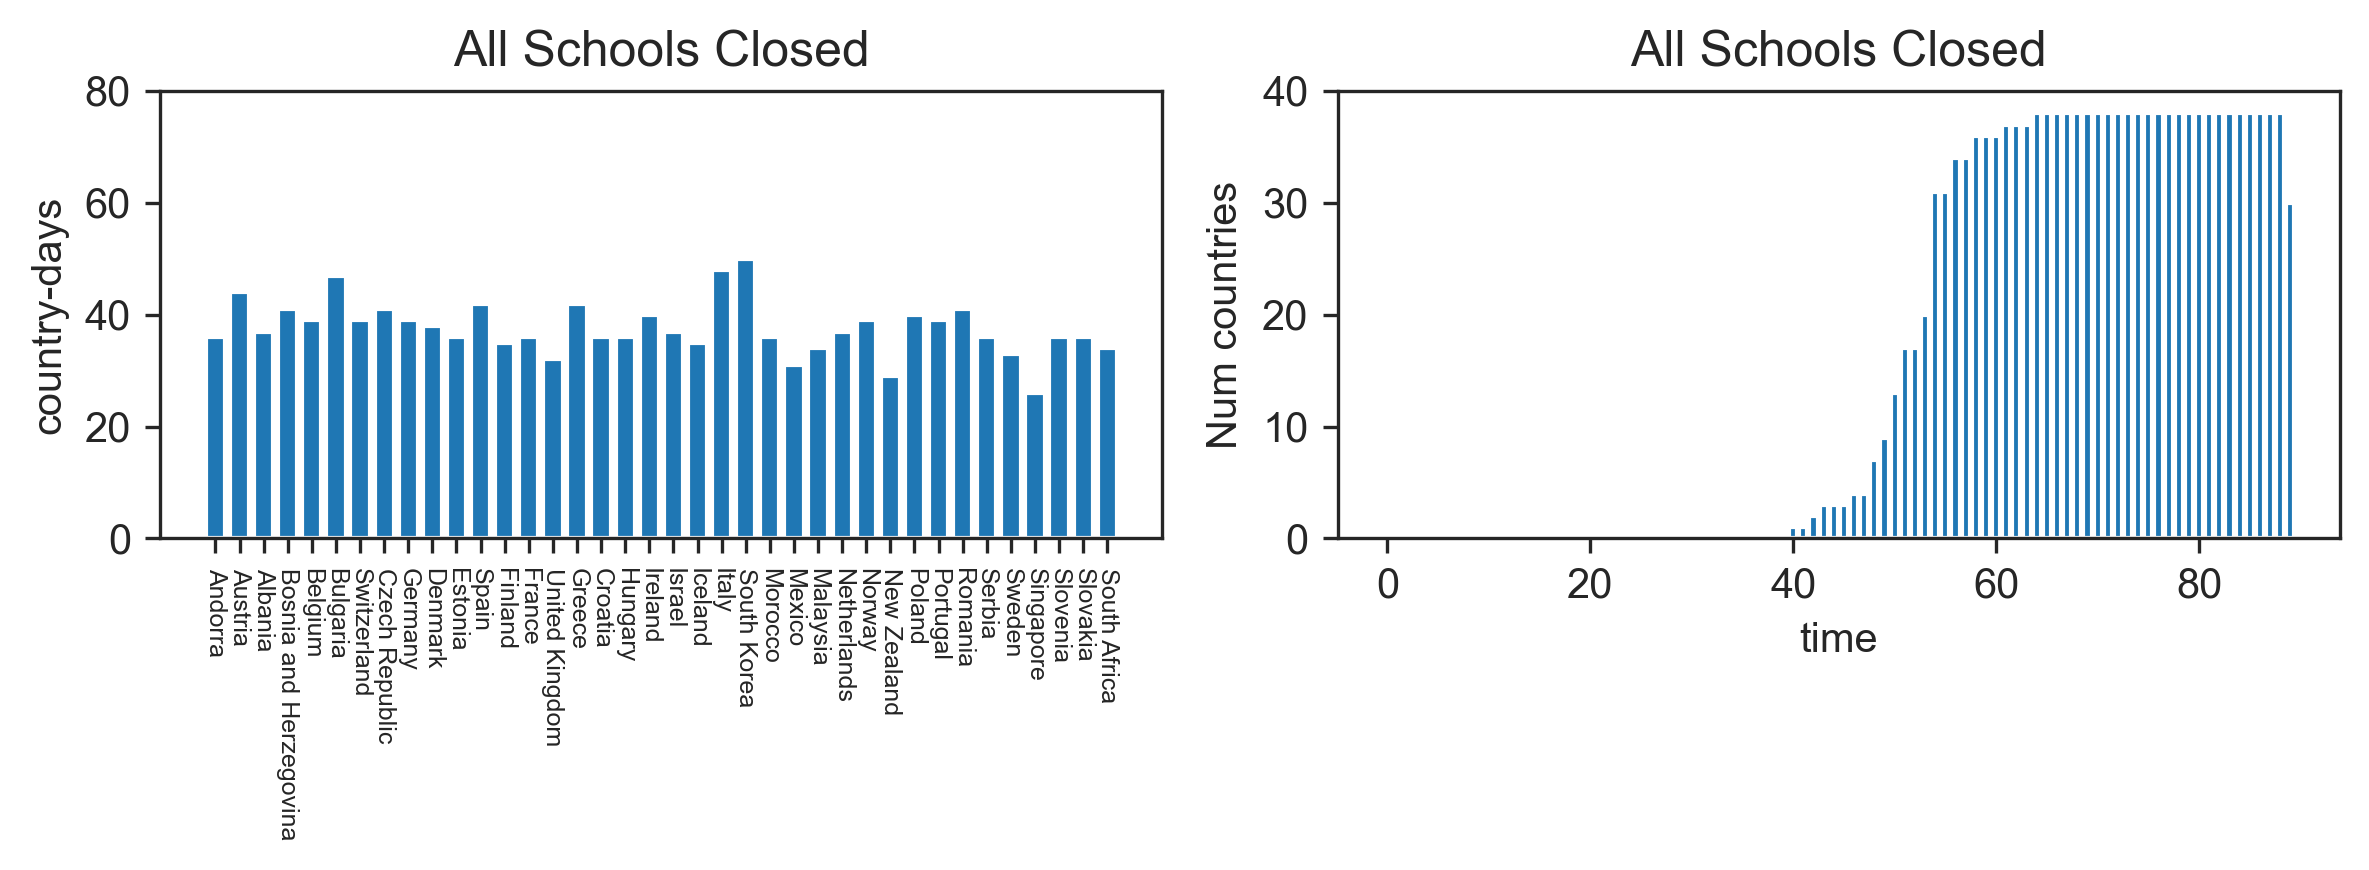

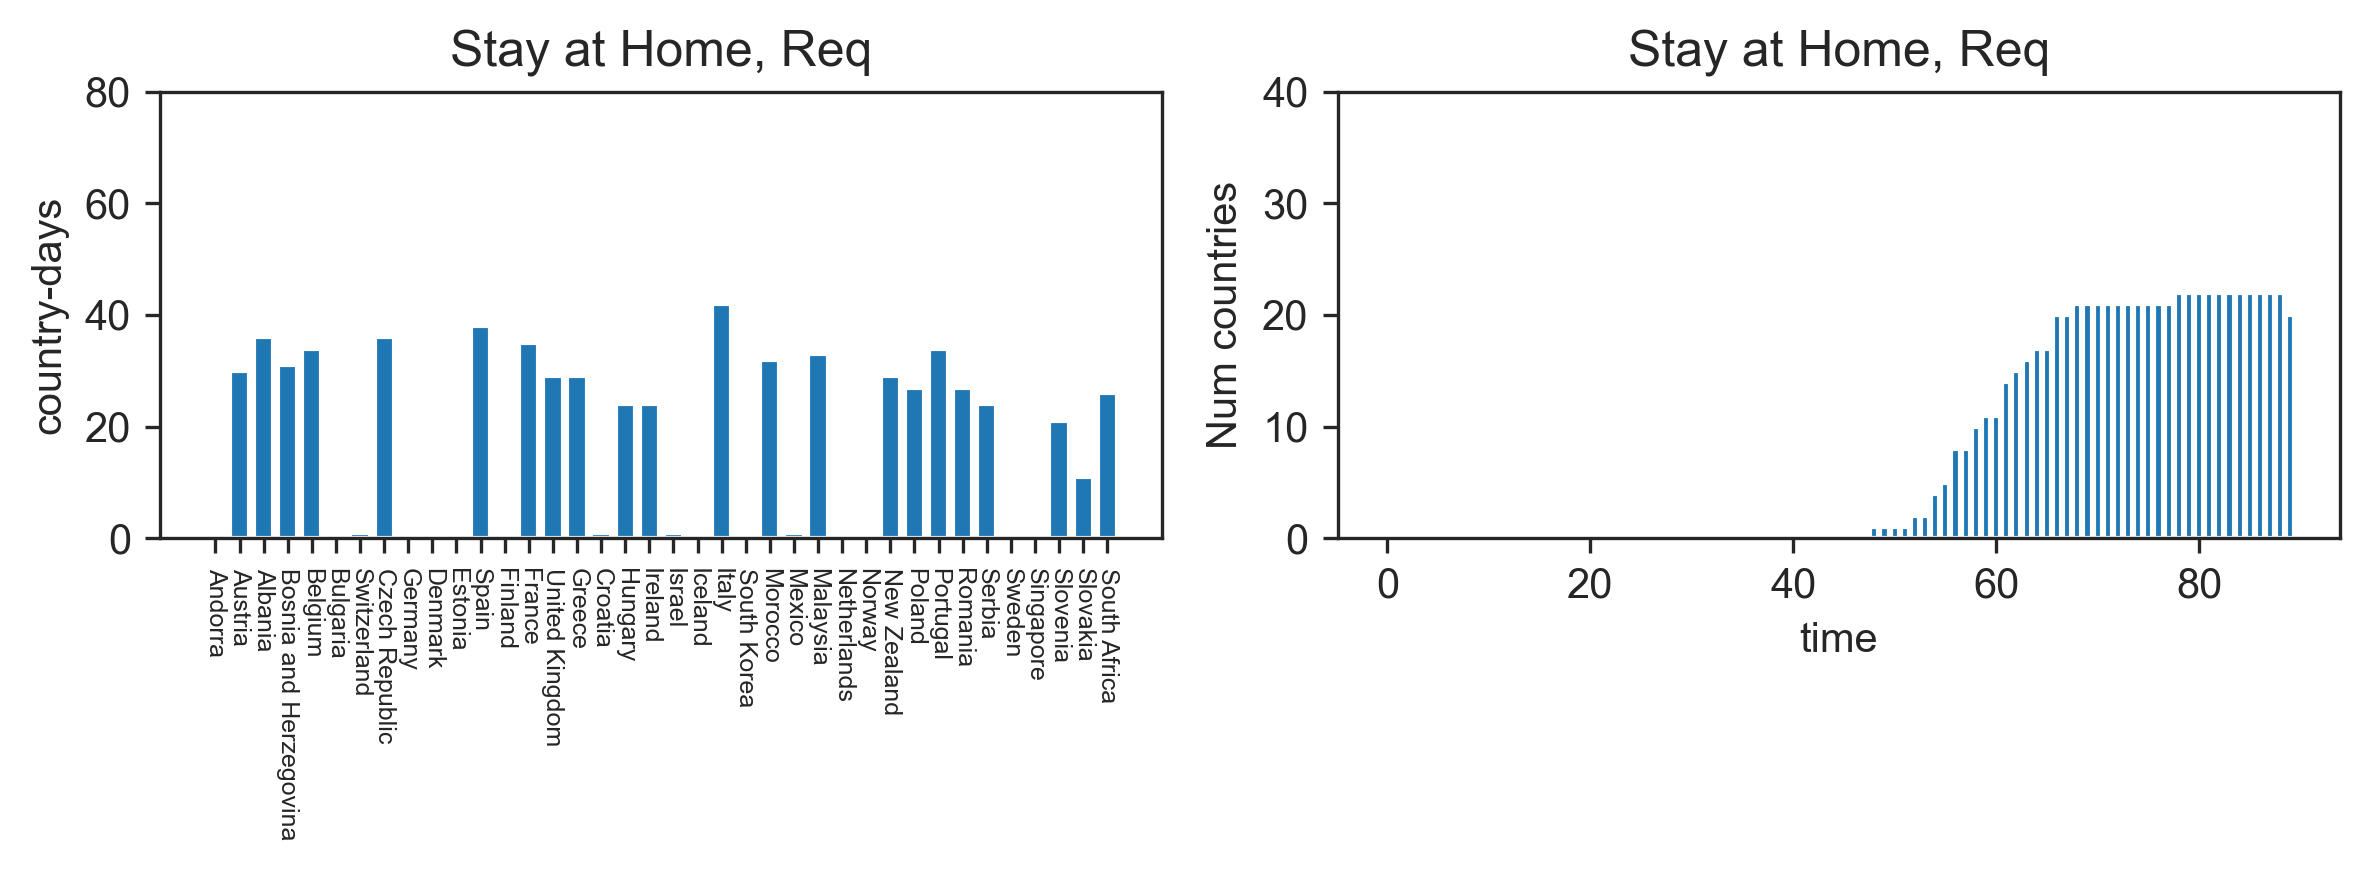

In [74]:
for indx, cm in enumerate(final_features_ordered):
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=1)
    plt.figure(figsize=(8, 3), dpi=300)
    plt.subplot(121)
    plt.bar(np.arange(len(region_names)), hist_data)
    plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
    plt.ylim([0, 80])
    plt.ylabel("country-days")
    plt.title(cm)
    plt.subplot(122)
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=0)
    plt.bar(np.arange(hist_data.size), hist_data)
    plt.title(cm)
    plt.ylim([0, 40])
    plt.ylabel("Num countries")
    plt.xlabel("time")
    plt.tight_layout()

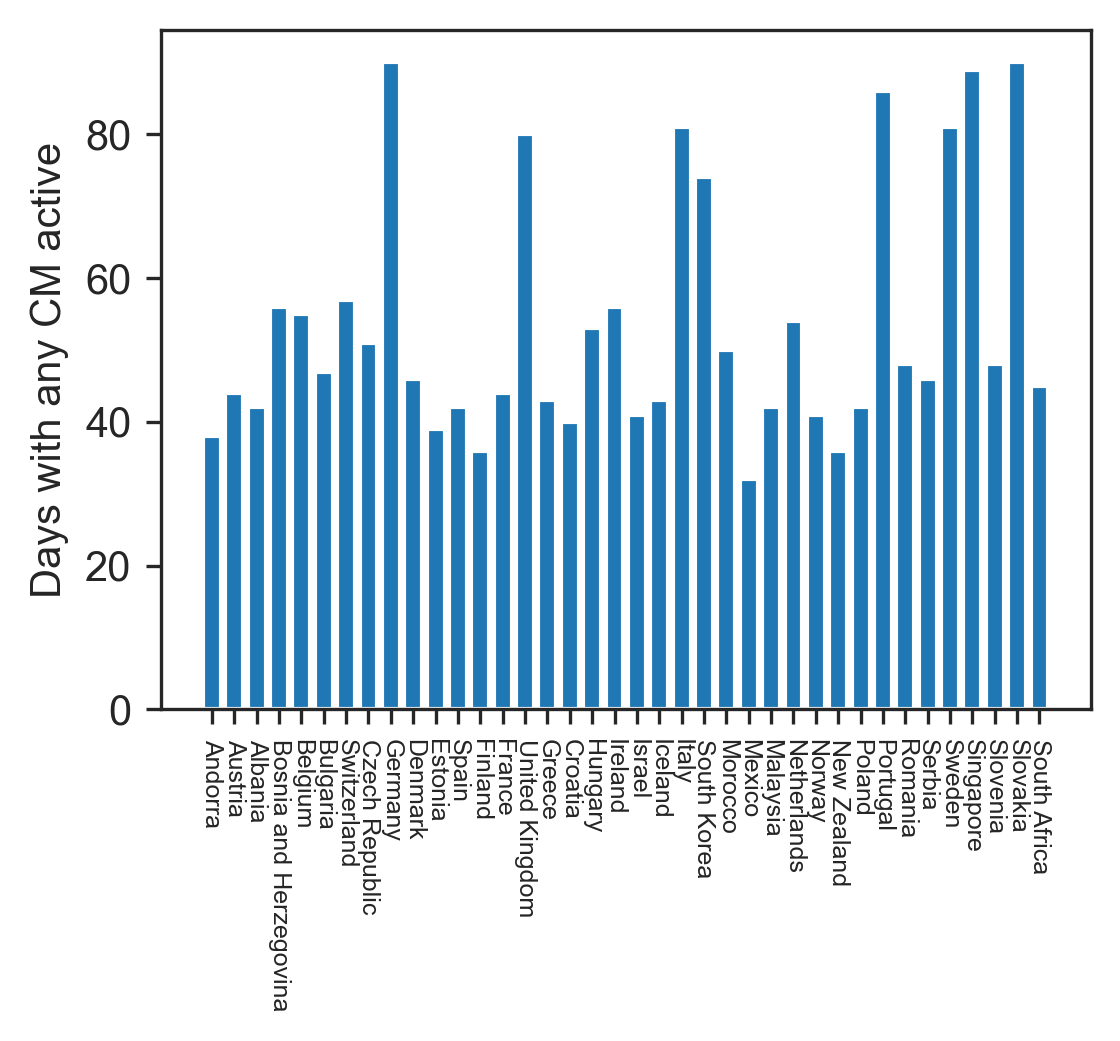

In [75]:
plt.figure(figsize=(4, 3), dpi=300)
cs = np.sum(np.sum(ActiveCMs[:, :, :], axis=1) > 0, axis=-1)
plt.bar(np.arange(len(region_names)), cs)
plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
plt.ylabel("Days with any CM active");

In [116]:
from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"/Users/mrinank/workspace/fonts/Font Awesome 5 Free-Solid-900.otf")

final_features_ordered = [
    'Healthcare specialisation - limited', 
    "Healthcare specialisation", 
    "Symptomatic Testing",
    "Public Testing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Business suspended - some",
    "Business suspended - many",
    "Gatherings lim. 1000",    
    "Gatherings lim. 100",
    "Gatherings lim. 10",
    "All Schools Closed",
    "Stay at Home, Req"
]

display_with = [
    [1], [], [3], [], 
    [], [], [7], [], 
    [9, 10], [10], [], [], [] 
]

plot_style = [
            ("\uf7f2", "tomato"),
            ("\uf7f2", "tab:red"),
            ("\uf492", "lightskyblue"),
            ("\uf492", "mediumblue"),
            ("\uf002", "black"),
            ("\uf963", "black"),
            ("\uf07a", "tab:orange"),
            ("\uf07a", "tab:red"),
            ("\uf968", "silver"),
            ("\uf968", "grey"),
            ("\uf968", "black"),
            ("\uf19d", "black"),
            ("\uf965", "black")
        ]


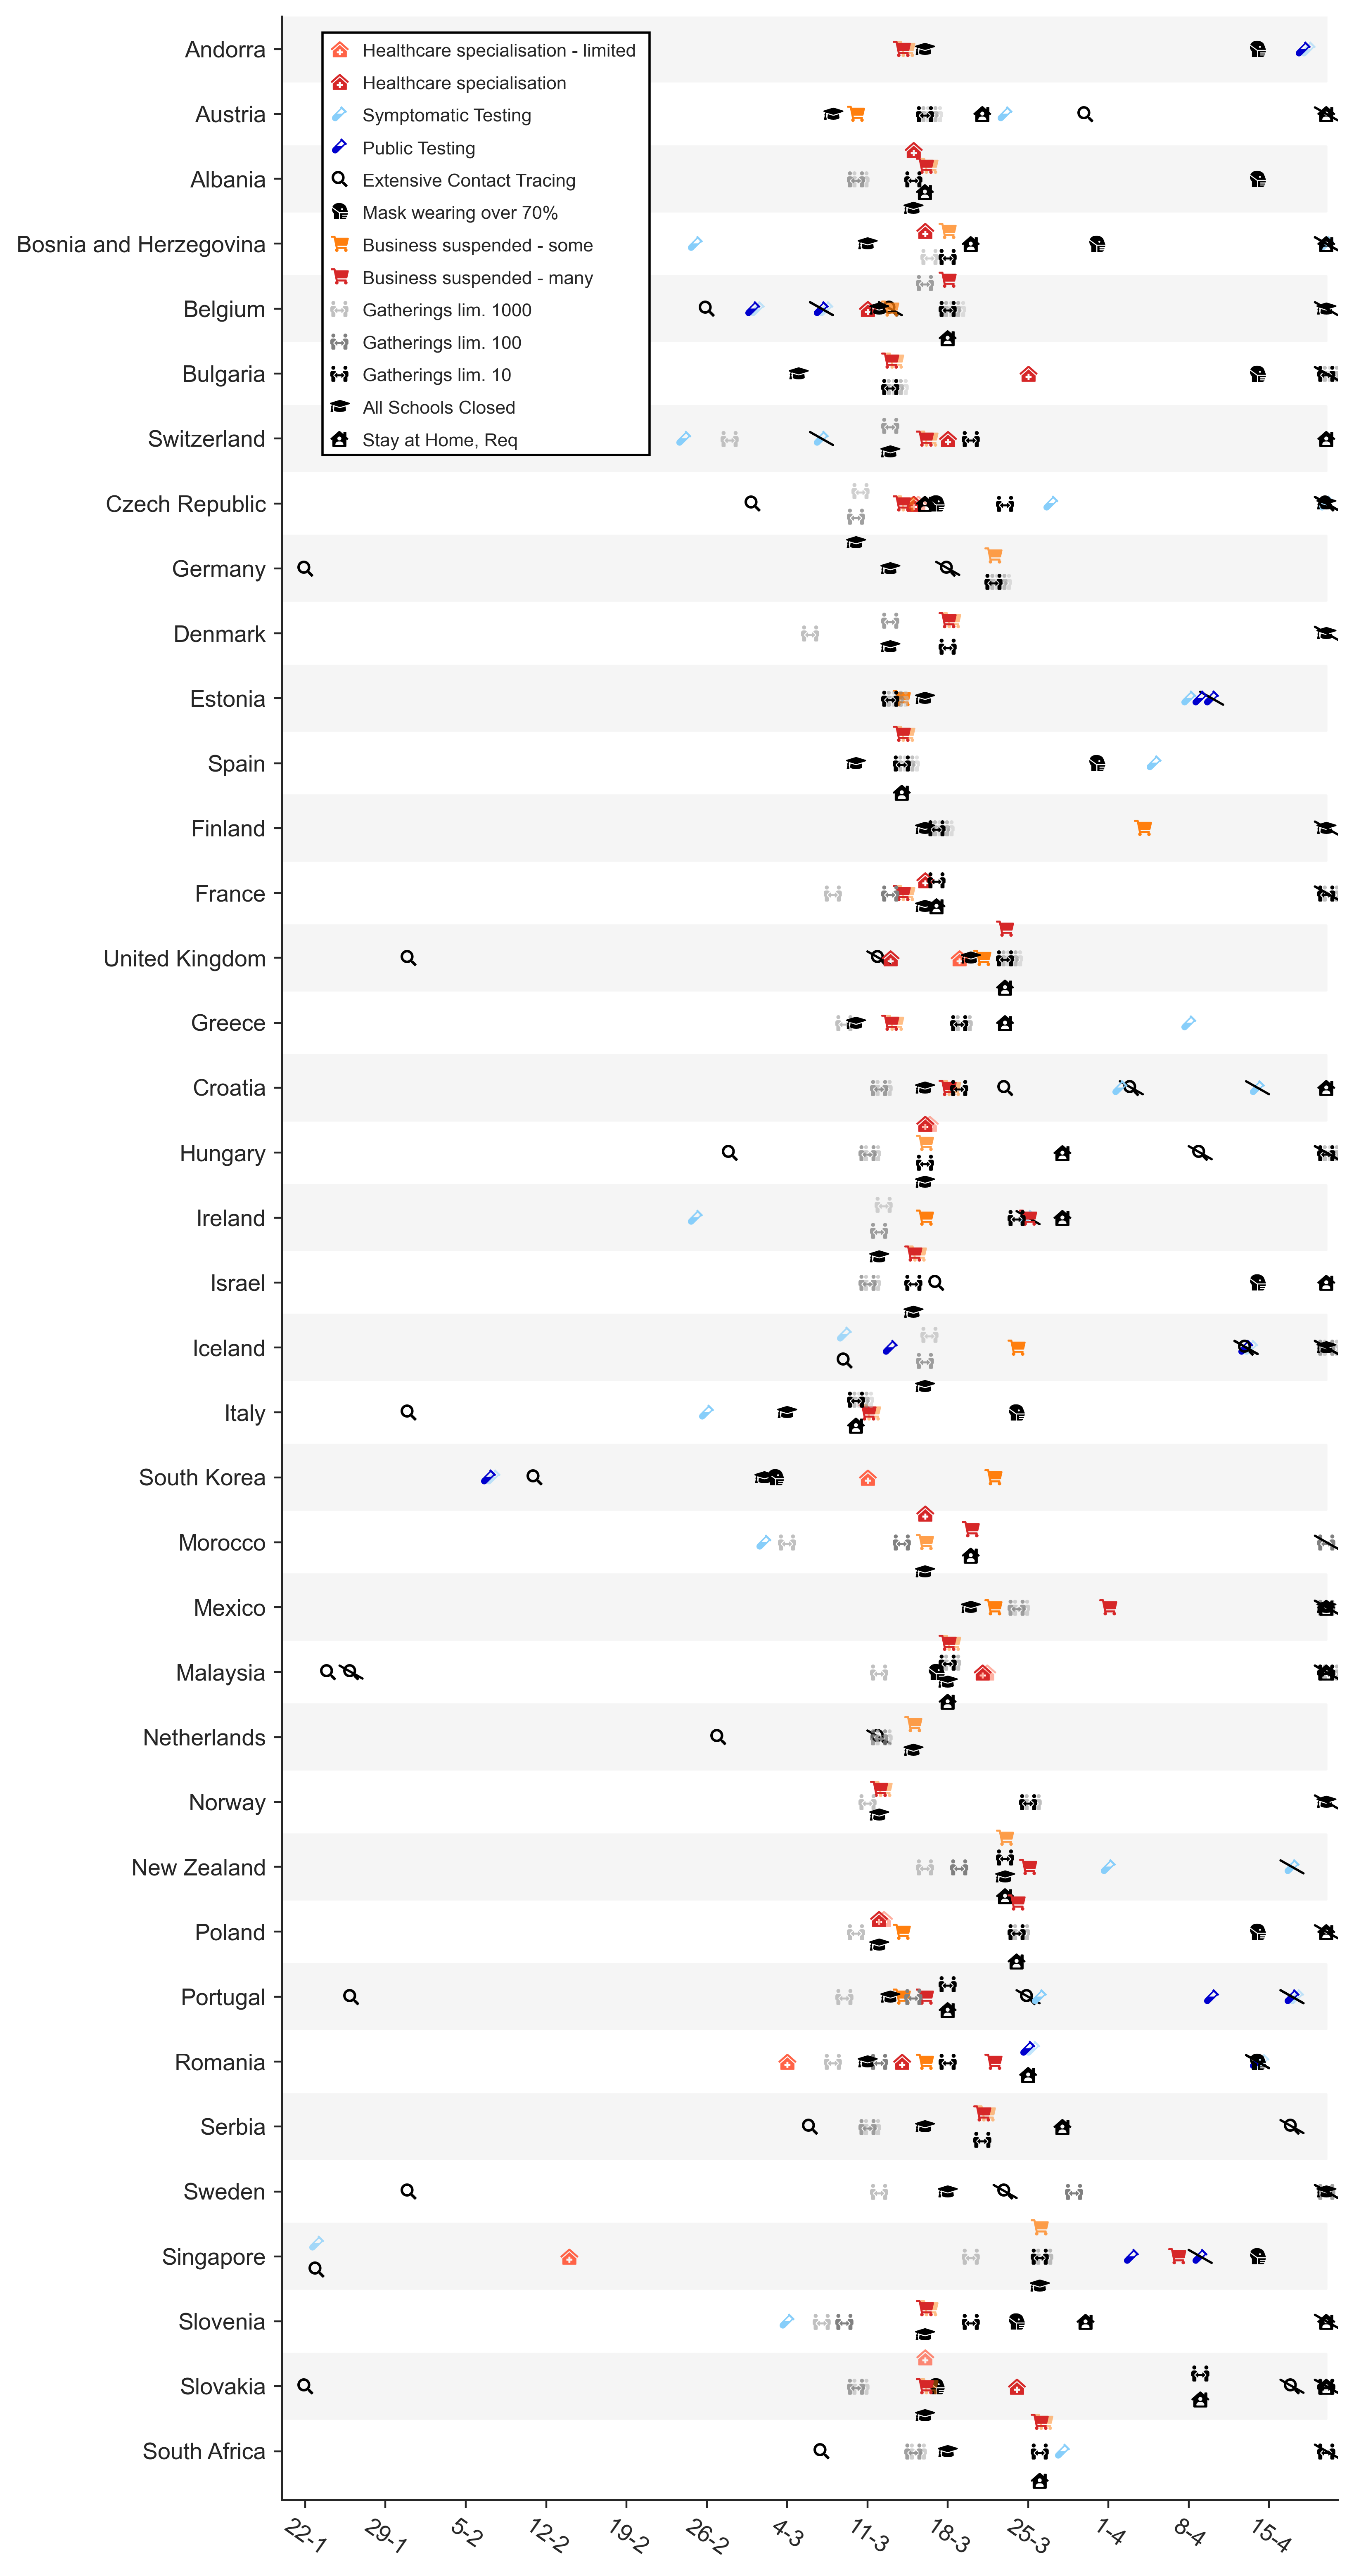

In [159]:
dts = data.Ds
nDs = len(dts)
nRs = len(data.Rs)

x_min = -2
x_max = nDs

spread_small = 0.4
spread_large = 0.9

fig = plt.figure(figsize=(8.3, 15.7), dpi=400)

for height in range(0, nRs, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="whitesmoke")

feature_counts = np.zeros(len(final_features_ordered))
days_x = np.arange(len(dts))

for d_indx, region in enumerate(region_info):
    all_cm_values = ActiveCMs[d_indx, :, :]
    region_height = -d_indx
    
    a_cm_changes = np.zeros_like(all_cm_values)
    a_cm_changes[:, 1:] = (all_cm_values[:, 1:] - all_cm_values[:, :-1])
    
    all_cm_changes = np.zeros(all_cm_values[0, :].size)
    all_cm_changes[1:] = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    all_cm_changes[0] = np.sum(all_cm_values[:, 0])
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(final_features_ordered):
        cm_values = all_cm_values[indx, :]
        cm_changes = np.zeros(cm_values.size)
        cm_changes[1:] = cm_values[1:] - cm_values[:-1]
        cm_changes[0] = 1 if cm_values[0] == 1 else 0
        
        nz = (np.nonzero(cm_changes)[0]).tolist()
        
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val]
            
            delta_x = 0
            alpha = 1
            height = region_height
            
            if all_changes > 1:
                effective_changes = 0
                for cm in range(nCMs):
                    if a_cm_changes[cm, nz_val] == 1:
                        if len(display_with[cm]) > 0:
                            for other_display in display_with[cm]:
                                if a_cm_changes[other_display, nz_val] == 1.0:
                                    break
                                else:
                                    effective_changes += 1
                        else:
                            effective_changes += 1

                if effective_changes > 2:
                    spread = spread_large
                else:
                    spread = spread_small
                
                if effective_changes > 1:
                    height = (region_height + spread/2) - ((spread/(effective_changes-1)) * cum_changes[nz_val])
                else:
                    height = region_height
                
                if len(display_with[indx]) > 0:
                    for other_display in display_with[indx]:
                        if a_cm_changes[other_display, nz_val] != 0:
                            delta_x += 0.4
                            alpha = 0.5
                        else:
                            cum_changes[nz_val] += 1
                            alpha = 0.75
                else:
                    cum_changes[nz_val] += 1
                
            if cm_changes[nz_val] == 1.0:
                if feature_counts[indx] == 0:
                    if indx > 0:
                        if feature_counts[indx - 1] > 0:
                            plt.text(nz_val + delta_x, height, plot_style[indx][0], fontproperties=fp2, color=plot_style[indx][1],  size=7,alpha=alpha, va='center', ha='center', clip_on=True)
                            feature_counts[indx] += 1
                        else:
                            plt.text(nz_val + delta_x, height, plot_style[indx][0],fontproperties=fp2,  color=plot_style[indx][1],  size=7,alpha=alpha, va='center', ha='center', clip_on=True)
                    else:
                        plt.text(nz_val  + delta_x, height, plot_style[indx][0],fontproperties=fp2,  color=plot_style[indx][1],  size=7,alpha=alpha, va='center', ha='center', clip_on=True)
                        feature_counts[indx] += 1
                else:
                    plt.text(nz_val + delta_x, height, plot_style[indx][0], fontproperties=fp2, color=plot_style[indx][1], size=7, alpha=alpha, va='center', ha='center', clip_on=True)
            
            elif cm_changes[nz_val] == -1:
                plt.text(nz_val + delta_x, height,plot_style[indx][0], fontproperties=fp2,  color=plot_style[indx][1], size=7, alpha=alpha, va='center', ha='center', clip_on=True, zorder=1)
                plt.plot([nz_val-1, nz_val+1], [height+0.1, height-0.1], linewidth=1, color="black", zorder=2)
            
            else:
                print(f"Something weird Region {region[0]} NPI: {f} {cm_changes[nz_val-1]}")
        
locs = np.arange(0, nDs, 7)
xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]

import matplotlib.patches as patches

rect = patches.Rectangle((x_min + 3.5, -0.5*len(final_features_ordered) + 0.25), 28.5, 0.5*len(final_features_ordered) , linewidth=1, edgecolor='black', facecolor='white')
plt.gca().add_patch(rect)
for indx, f in enumerate(final_features_ordered):
    plt.text(x_min + 5, -0.5*indx , plot_style[indx][0], fontproperties=fp2,  color=plot_style[indx][1], size=7, va='center', ha='center', clip_on=True, zorder=1)
    plt.text(x_min + 7, -0.5*indx - 0.05, f, size=8, va='center', ha='left')

plt.xticks(locs, xlabels, rotation=-35)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(region_names)), region_names)
plt.ylim([-nRs+0.25, 0.5])
sns.despine()
plt.tight_layout()
plt.savefig("time.pdf")